In [1]:
import json
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import Counter, defaultdict
plt.rcParams["figure.figsize"] = (20, 5)

## Train

In [2]:
record_path = Path("simulation_result/multi/all_250_volume0_no_stockratio_epoch100")
num_train_dirs = len(os.listdir(record_path / 'train'))
num_validate_dirs = len(os.listdir(record_path / 'validate'))
train_dirs = [record_path / 'train' / f'sim_{i}' for i in range(num_train_dirs)]
validate_dirs = [record_path / 'validate' / f'sim_{i}' for i in range(num_validate_dirs)]
config_path = record_path / 'config.json'

In [3]:
config = (json.loads(config_path.read_text()))
num_agent = sum([agent_config['number'] for agent_config in config['Agent']['RLAgent']])

In [4]:
import json

train_markets, train_agents, train_rl_states, train_lengths, train_timesteps = [], [], [], [], []
for _dir in train_dirs:
    security_path = _dir / "TSMC.json"
    agent_path = _dir / "agent.json"
    rl_path = _dir / 'rl_agent.json'
    config_path = _dir / 'config.json'
    market = json.loads(security_path.read_text())
    train_markets.append(market)
    train_agents.append(json.loads(agent_path.read_text()))
    train_rl_states.append(json.loads(rl_path.read_text()))
    train_lengths.append(len(market['price']))
    train_timesteps.append([i for i in range(len(market['price']))])


In [8]:
markets = train_markets
agents = train_agents
rl_states = train_rl_states
lengths = train_lengths
timesteps = train_timesteps
print(f"Average training length: {sum(lengths) / len(lengths)}")

Average training length: 500.0


### Price & Value

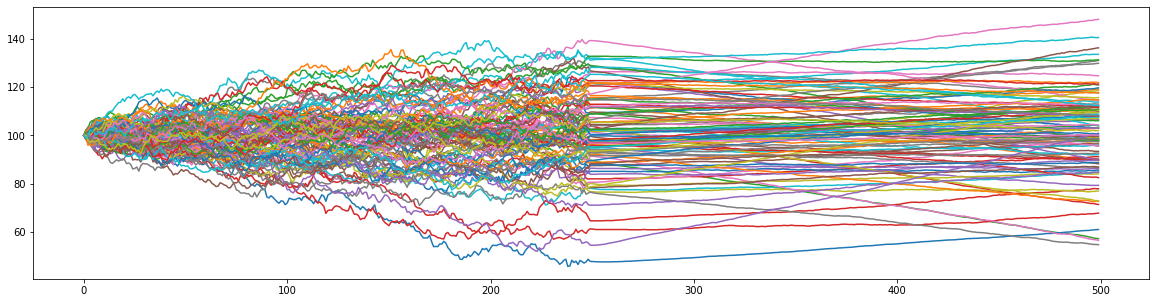

In [9]:
for market in markets:
    plt.plot(market['price'])

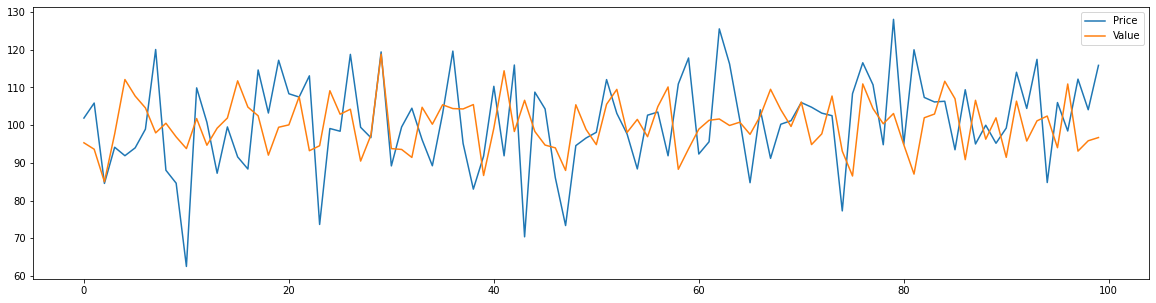

In [10]:
# Average price & value
avg_prices, avg_values = [], []
for market in markets:
    avg_prices.append(sum(market['price']) / len(market['price']))
    avg_values.append(sum(market['value']) / len(market['value']))

plt.plot(avg_prices, label = 'Price')
plt.plot(avg_values, label = 'Value')
plt.legend()

### Bid & Ask

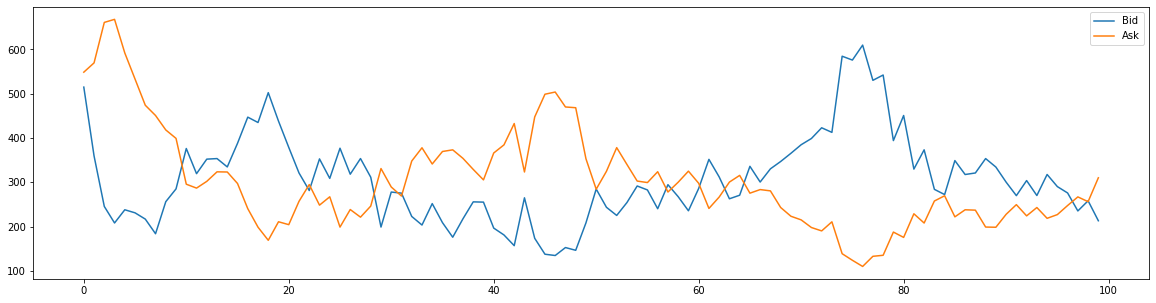

Average step per bid quantity per agent: 1.6266322115600458
Average step per ask quantity per agent: 1.6502037935676903


In [11]:
avg_bids, avg_asks = [], []
for market in markets:
    avg_bids.append(sum(market['bid']) / len(market['bid']))
    avg_asks.append(sum(market['ask']) / len(market['ask']))

plt.plot(avg_bids, label = 'Bid')
plt.plot(avg_asks, label = 'Ask')
plt.legend()
plt.show()
print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / num_agent)}")
print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / num_agent)}")

In [294]:
# # train
# for market in markets:
#     plt.plot(market['price'], label = 'price')
#     plt.plot(market['value'], label = 'value')
#     plt.legend()
#     plt.show()


In [295]:
# for market in markets:
#     plt.plot(market['bid'], label = 'Bid quantity')
#     plt.plot(market['ask'], label = 'Ask quantity')
#     plt.legend()
#     plt.show()

### Agent returns

#### Distribution of total returns 

In [13]:
all_agent_returns = []
for rl_state in rl_states:
    for agent_state in rl_state.values():
        returns = (agent_state['states'][-1]['wealth'] - agent_state['states'][0]['wealth']) / agent_state['states'][0]['wealth']
        all_agent_returns.append(round(returns * 100))

In [14]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])

Rate of positive returns: 0.7288985148514852
Rate of negtive returns: 0.27110148514851484


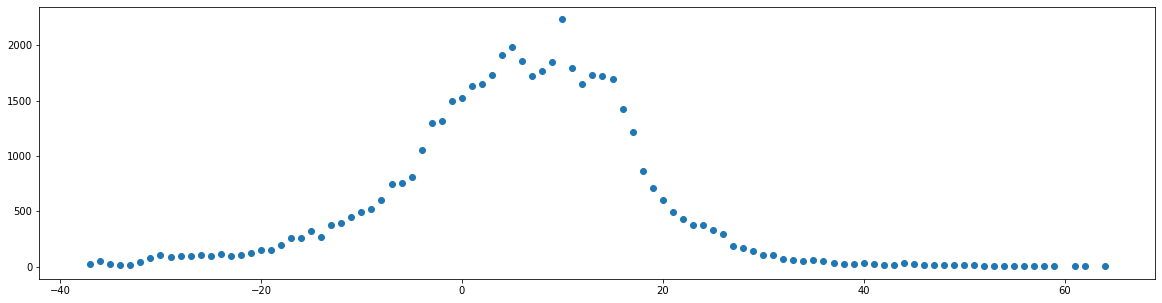

In [15]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
agent_returns_counter = Counter(all_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)
print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")

#### Distribution of returns by agent

In [16]:
agent_ids = rl_states[0].keys()
agent_returns = {agent_id: [] for agent_id in agent_ids}

for rl_state in rl_states:
    for agent_id, agent_state in rl_state.items():
        returns = (agent_state['states'][-1]['wealth'] - agent_state['states'][0]['wealth']) / agent_state['states'][0]['wealth']
        agent_returns[agent_id].append(round(returns * 100, 2))

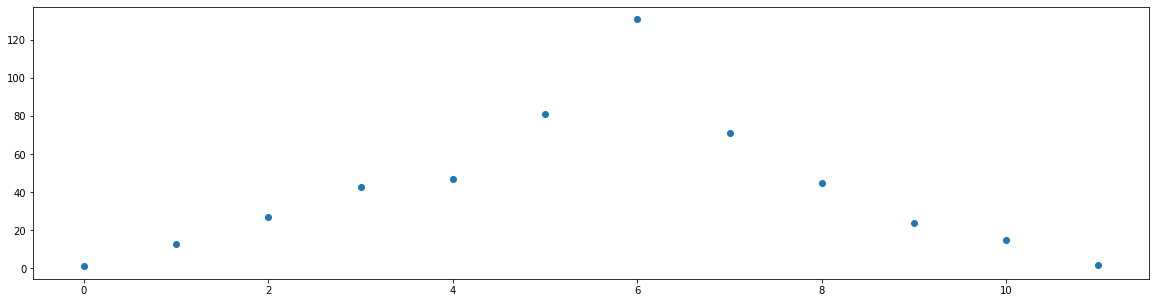

In [17]:
avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
agent_returns_counter = Counter(avg_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)

Positive progress: 0.894
Negative progress: 0.106


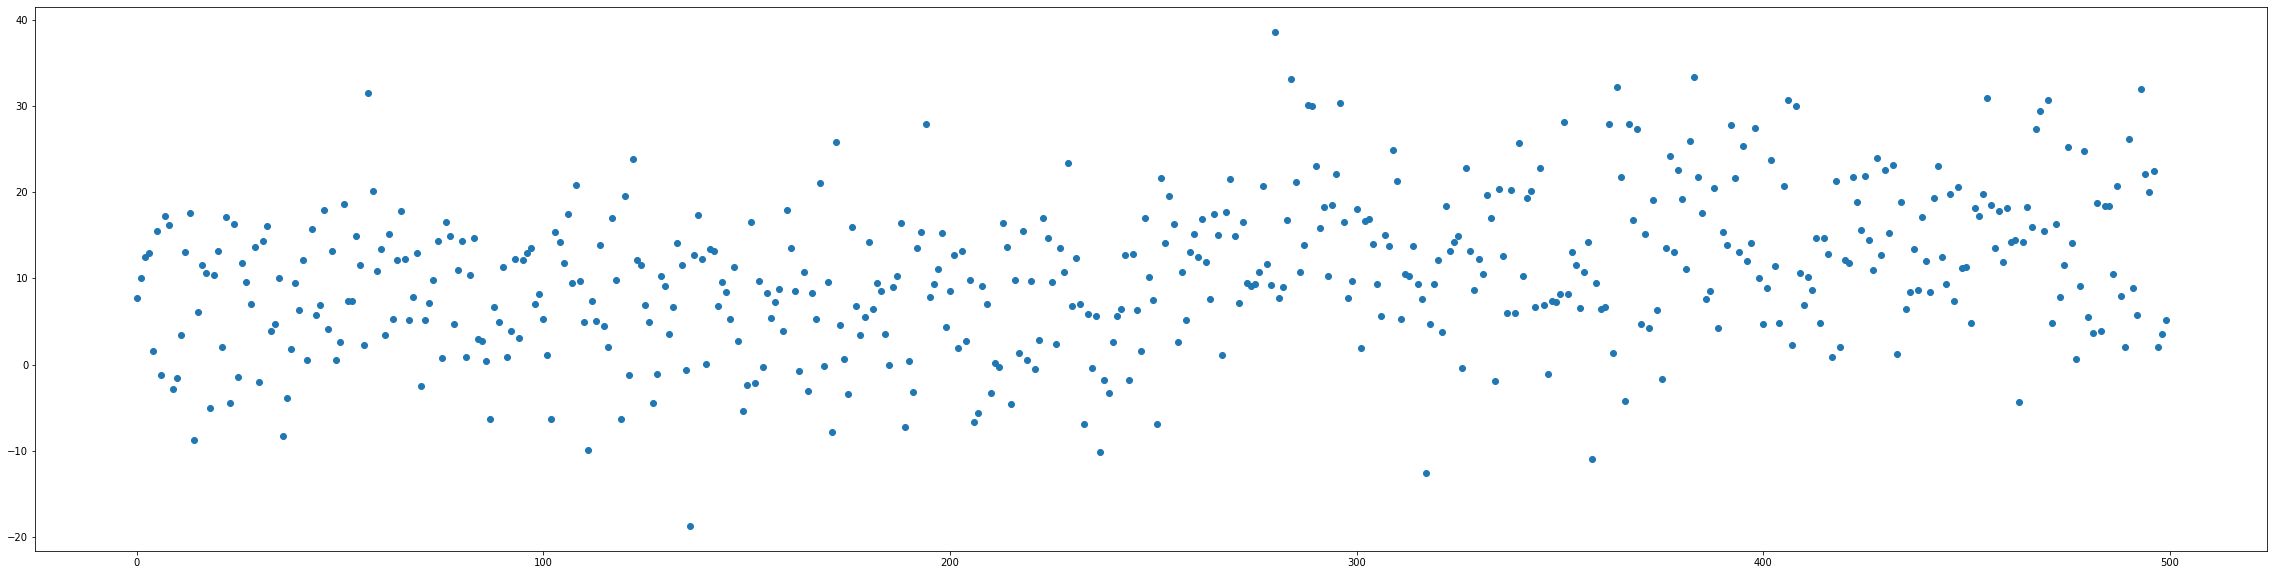

In [18]:
plt.figure(figsize=(40, 10))
returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
plt.scatter(list(range(len(returns_progress))), returns_progress)
num_pos_progress = len([progress for progress in returns_progress if progress > 0])
num_neg_progress = len([progress for progress in returns_progress if progress < 0])
print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
print(f"Negative progress: {num_neg_progress / len(returns_progress)}")


### Sample agent

In [725]:
# sample agent to analyse
agent_id = random.sample(agent_ids, 1)[0]
plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()


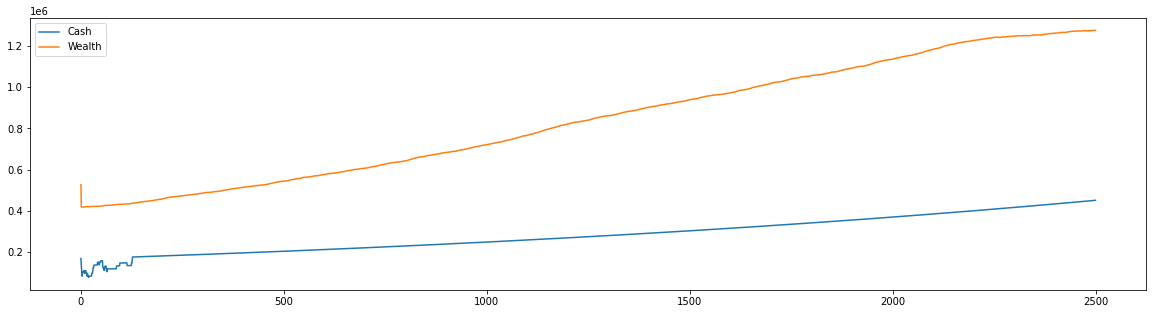

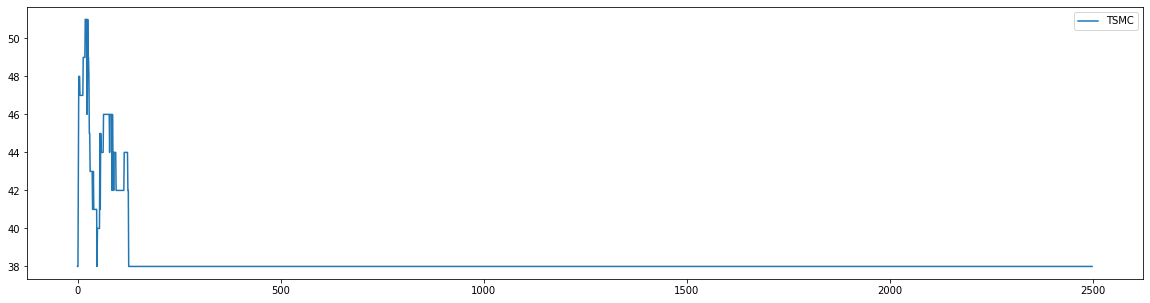

In [642]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

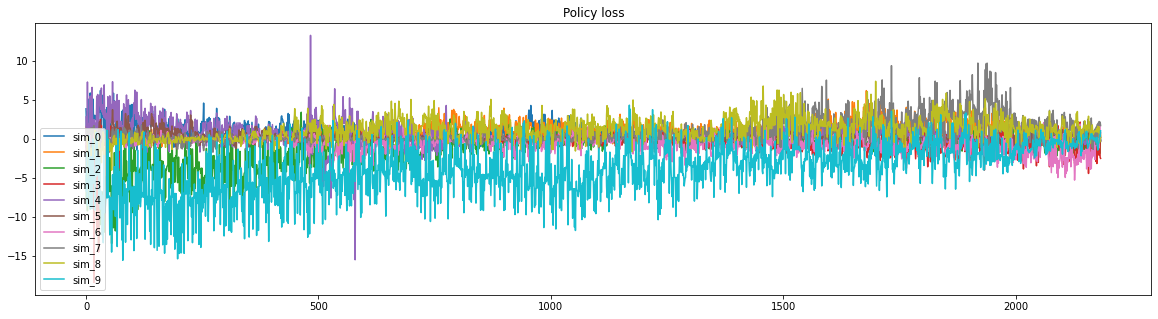

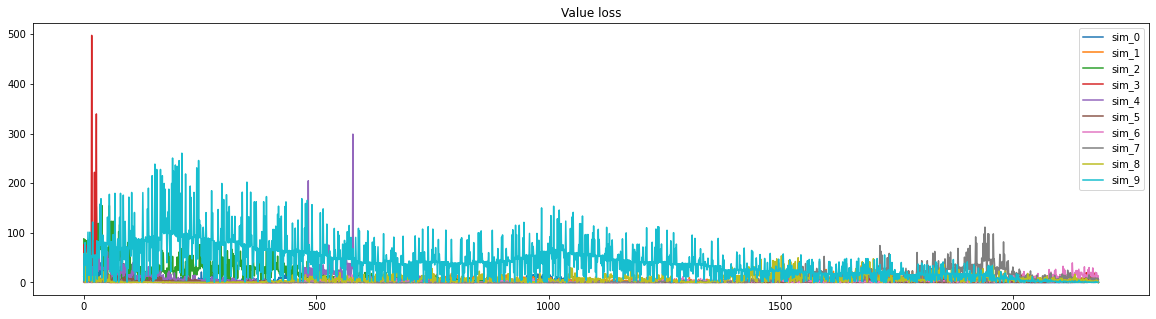

In [643]:
for i, states in enumerate(rl_states):
    plt.plot(states[agent_id]['policy_loss'], label = f"sim_{i}")
    plt.legend()
    plt.title('Policy loss')
plt.show()

for i, states in enumerate(rl_states):
    plt.plot(states[agent_id]['value_loss'], label = f"sim_{i}")
    plt.legend()
    plt.title('Value loss')
plt.show()


### Loss

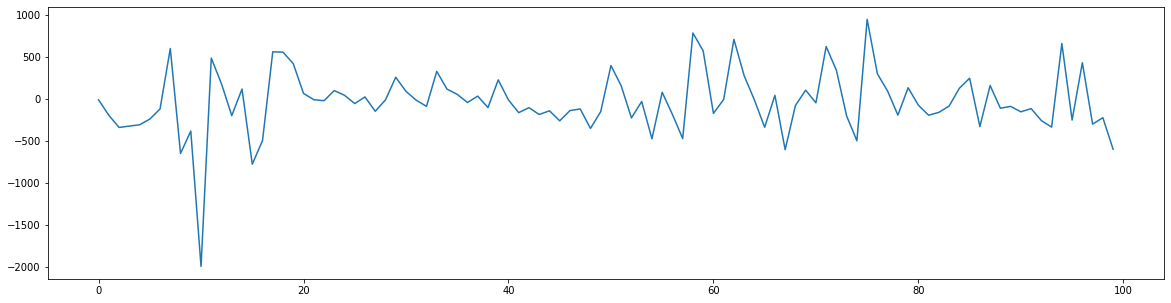

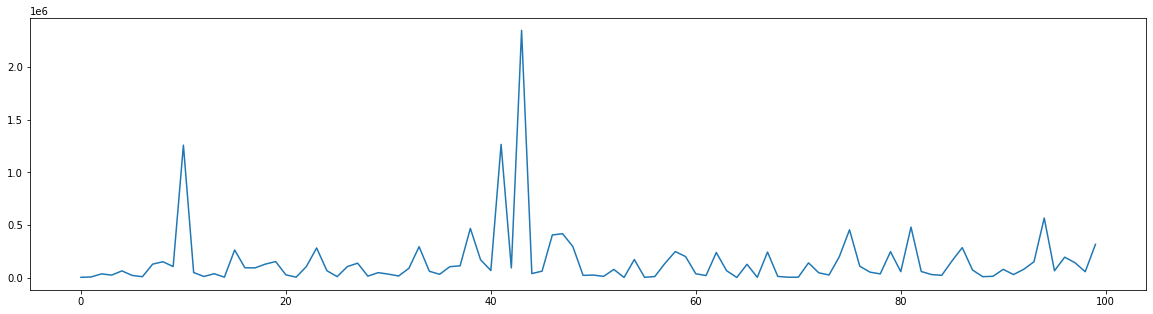

In [21]:
# Agent average loss
total_policy_loss = {}
total_value_loss = {}
length = len(markets[0]['price'][250:])
for agent_id in agent_ids:
    agent_policy_losses = []
    agent_value_losses = []
    for states in rl_states:
        agent_policy_loss = sum(states[agent_id]['policy_loss'])
        agent_value_loss = sum(states[agent_id]['value_loss'])
        agent_policy_losses.append(agent_policy_loss)
        agent_value_losses.append(agent_value_loss)
    total_policy_loss[agent_id] = agent_policy_losses
    total_value_loss[agent_id] = agent_value_losses

avg_policy_loss = [sum([total_policy_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
avg_value_loss = [sum([total_value_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
plt.plot(avg_policy_loss)
plt.show()
plt.plot(avg_value_loss)


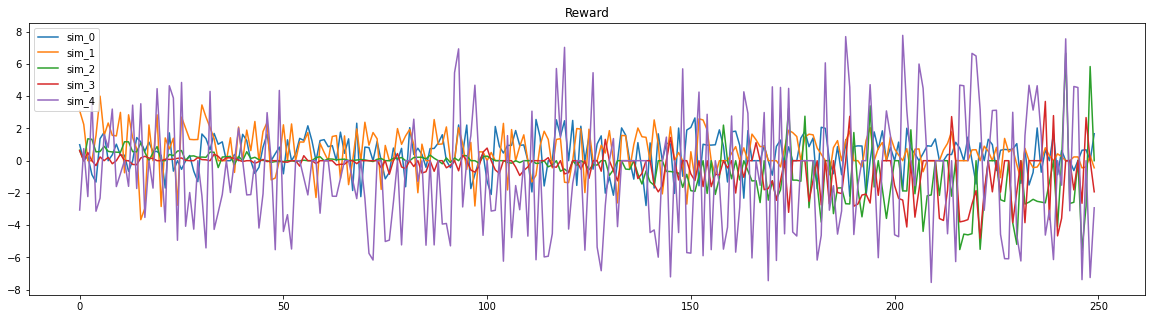

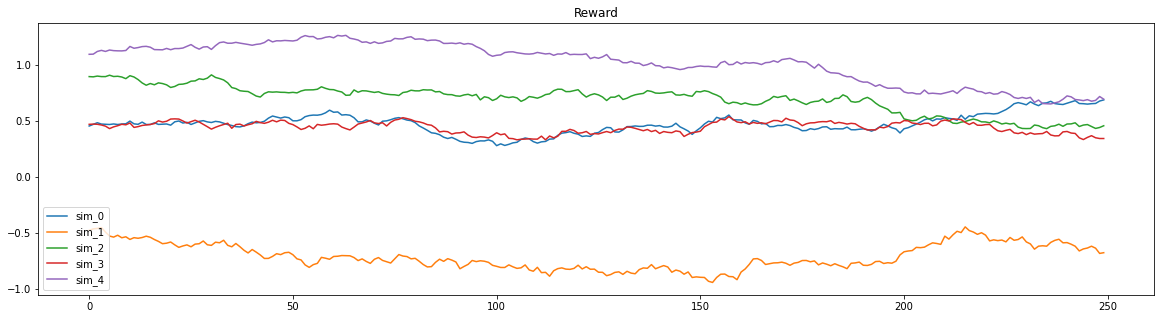

In [25]:
# for i, states in enumerate(rl_states):
#     weighted_reward = [reward['weighted_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(weighted_reward, label = f"sim_{i}")
# plt.legend()
# plt.title('Weighted reward')
# plt.show()

# for i, states in enumerate(rl_states):
#     wealth_reward = [reward['wealth_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(wealth_reward, label = f"sim_{i}")
# plt.legend()
# plt.title('Wealth reward')
# plt.show()
    
    
# for i, states in enumerate(rl_states):
#     action_reward = [reward['action_reward'] for reward in states[agent_id]['rewards']]
#     plt.plot(action_reward, label = f"sim_{i}")

# plt.legend()
# plt.title('Action reward')
# plt.show()

for i, states in enumerate(rl_states[:5]):
    action_reward = [reward for reward in states[agent_id]['rewards']]
    plt.plot(action_reward, label = f"sim_{i}")

plt.legend()
plt.title('Reward')
plt.show()

for i, states in enumerate(rl_states[-5:]):
    action_reward = [reward for reward in states[agent_id]['rewards']]
    plt.plot(action_reward, label = f"sim_{i}")

plt.legend()
plt.title('Reward')
plt.show()
# total_reward, wealth_reward, action_reward = [], [], []
# for reward in rl_state['rewards']:
#     total_reward.append(reward['weighted_reward'])
#     wealth_reward.append(reward['wealth_reward'])
#     action_reward.append(reward['action_reward'])

# for label, value in {'Total': total_reward, 'Wealth': wealth_reward}.items():
#     plt.plot(value, label = label)
# plt.legend()

### Actions

In [31]:
value_group_name = "ppo_va_250"
value_agent_number = 250
value_agent_id = f"{value_group_name}_{random.randint(0, 249)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1

In [32]:
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
orders = []
for i, action in enumerate(rl_states[-1][value_agent_id]['actions']):
    bid_or_ask = action_ref[action[0]]
    ticks = tick_ref[action[1]]
    price = market['price'][249+i] + tick_size * ticks
    volume = action[2] + 1
    order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
    orders.append(order)

In [33]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 10
for i, order in enumerate(orders):
    if order['bid_or_ask'] == 'BID':
#         if order['time'] > 5000 and order['time'] < 5100:
        bid_x.append(order['time'])
        bid_y.append(order['price'])
        bid_colors.append('r')
        bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
#         if order['time'] > 5000 and order['time'] < 5100:
        ask_x.append(order['time'])
        ask_y.append(order['price'])
        ask_colors.append('g')  
        ask_sizes.append(base_size * order['volume'])

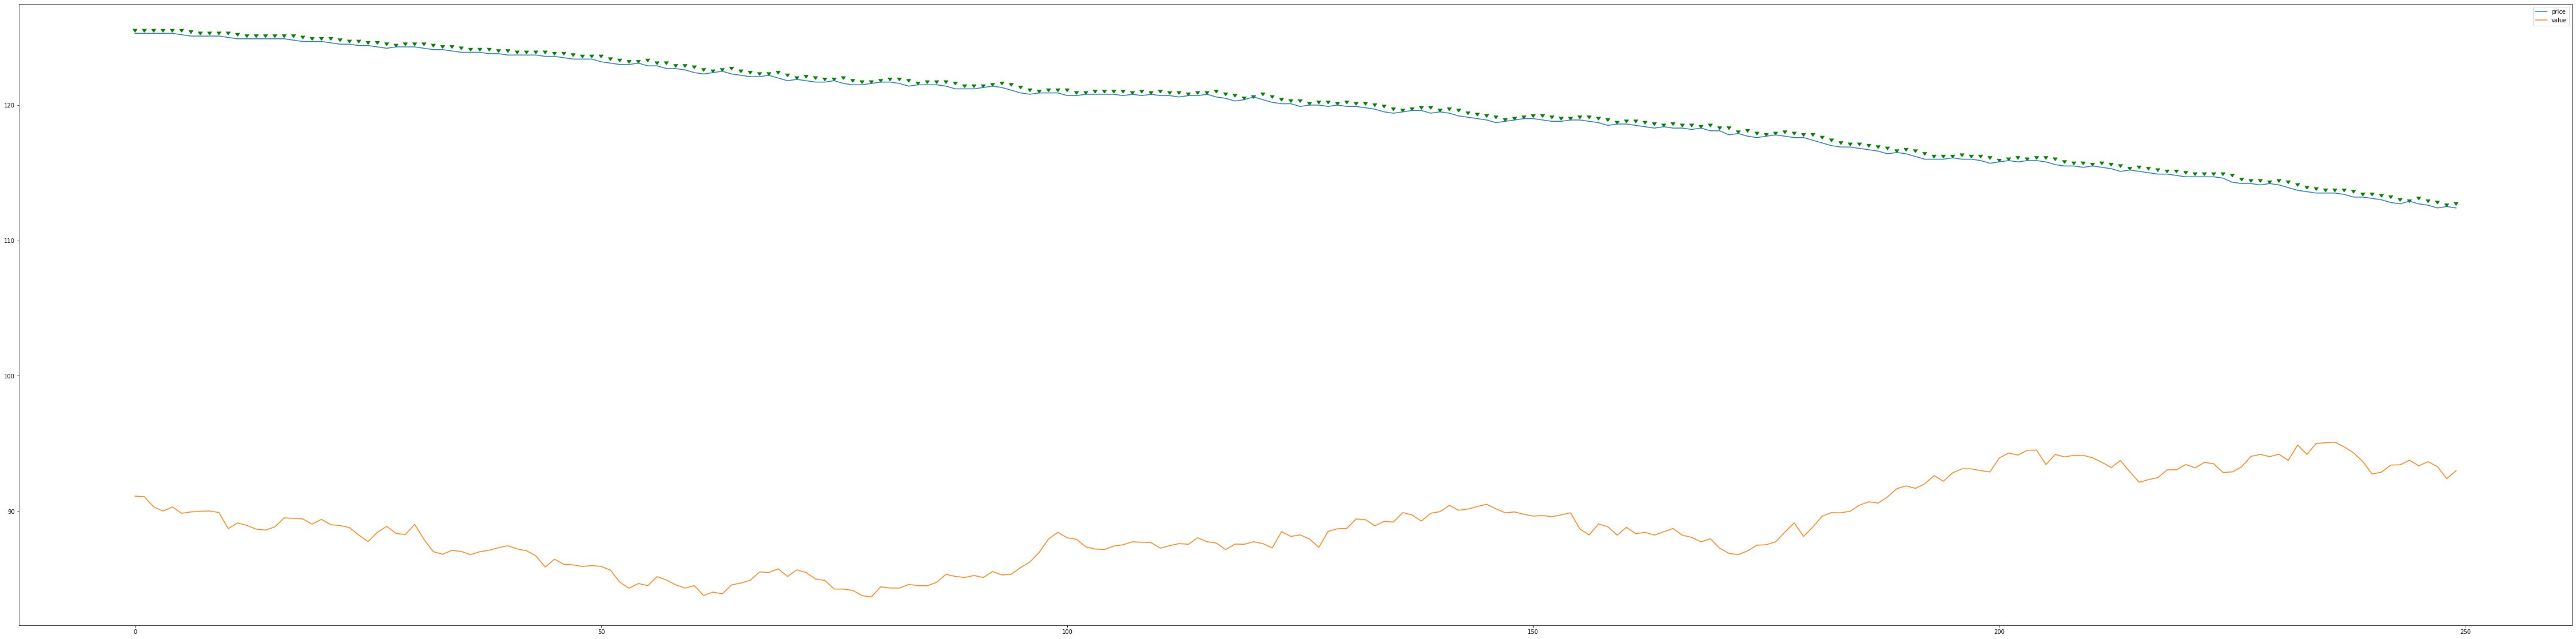

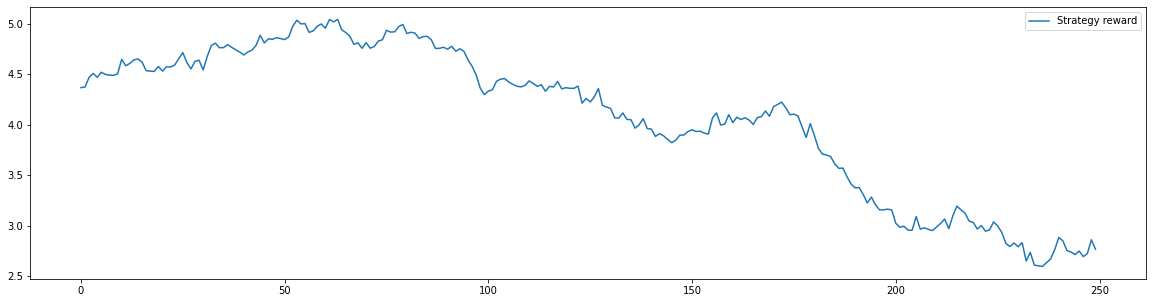

In [34]:
plot_price = market['price'][250:]
plot_value = market['value'][250:]
x = np.arange(len(plot_price))
plt.figure(figsize=(80, 20))
plt.plot(x, plot_price, label = "price")
plt.plot(x, plot_value, label = "value")
plt.legend()
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()

# weighted_reward = [reward['weighted_reward'] for reward in rl_state[value_agent_id]['rewards']]
# wealth_reward = [reward['wealth_reward'] for reward in rl_state[value_agent_id]['rewards']]
strategy_reward = [reward for reward in rl_state[value_agent_id]['rewards']]
# plt.plot(weighted_reward, label = "Total reward")
# plt.plot(wealth_reward, label = "Wealth reward")
plt.plot(strategy_reward, label = "Strategy reward")
plt.legend()
plt.show()


## Validate

In [6]:
val_markets, val_agents, val_rl_states, val_lengths, val_timesteps = [], [], [], [], []
for _dir in validate_dirs:
    security_path = _dir / "TSMC.json"
    agent_path = _dir / "agent.json"
    rl_path = _dir / 'rl_agent.json'
    config_path = _dir / 'config.json'
    market = json.loads(security_path.read_text())
    val_markets.append(market)
    val_agents.append(json.loads(agent_path.read_text()))
    val_rl_states.append(json.loads(rl_path.read_text()))
    val_lengths.append(len(market['price']))
    val_timesteps.append([i for i in range(len(market['price']))])

In [7]:
markets = val_markets
agents = val_agents
rl_states = val_rl_states
lengths = val_lengths
timesteps = val_timesteps
print(f"Average validate length: {sum(lengths) / len(lengths)}")

Average validate length: 2750.0


### Price & Value

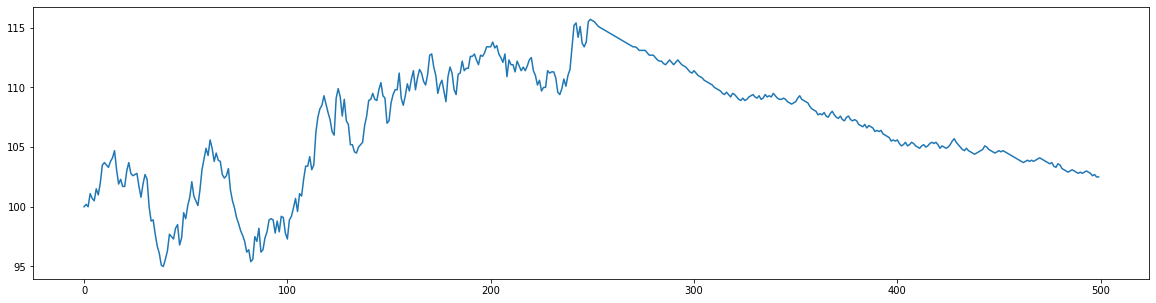

In [735]:
plt.plot(markets[-1]['price'][:500])

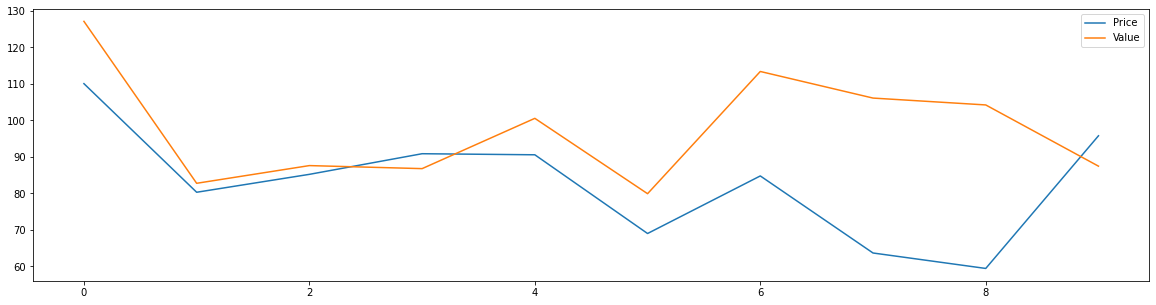

In [736]:
# Average price & value
avg_prices, avg_values = [], []
for market in markets:
    avg_prices.append(sum(market['price']) / len(market['price']))
    avg_values.append(sum(market['value']) / len(market['value']))

plt.plot(avg_prices, label = 'Price')
plt.plot(avg_values, label = 'Value')
plt.legend()

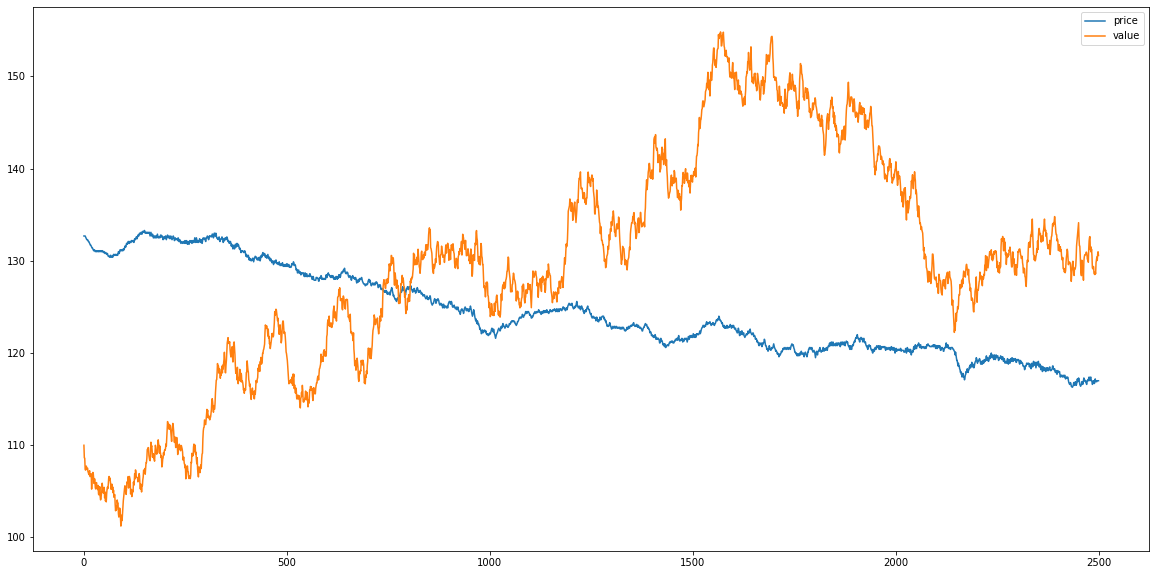

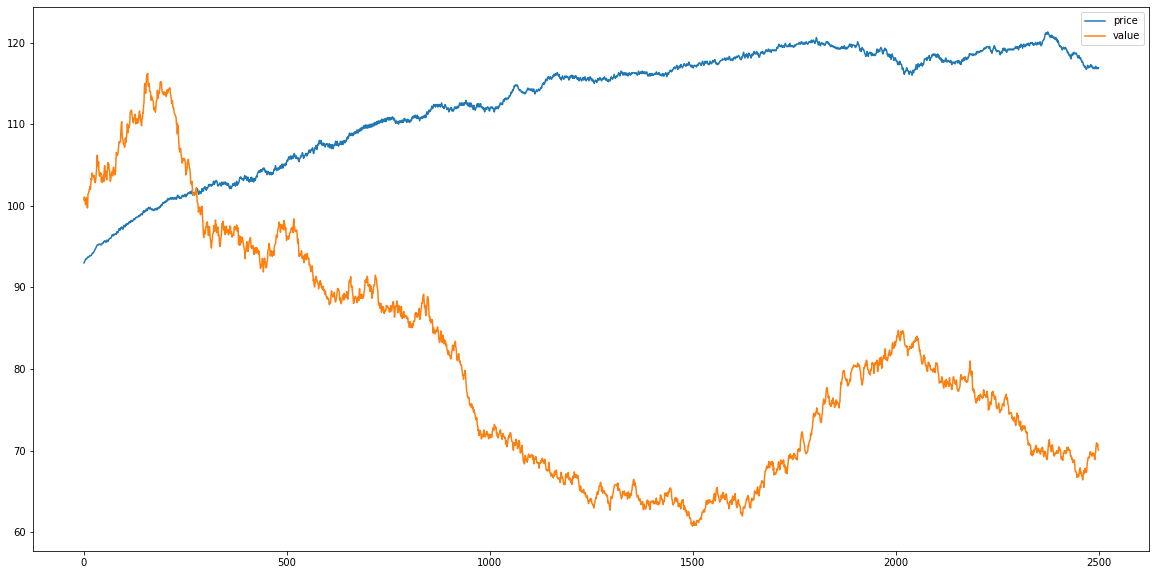

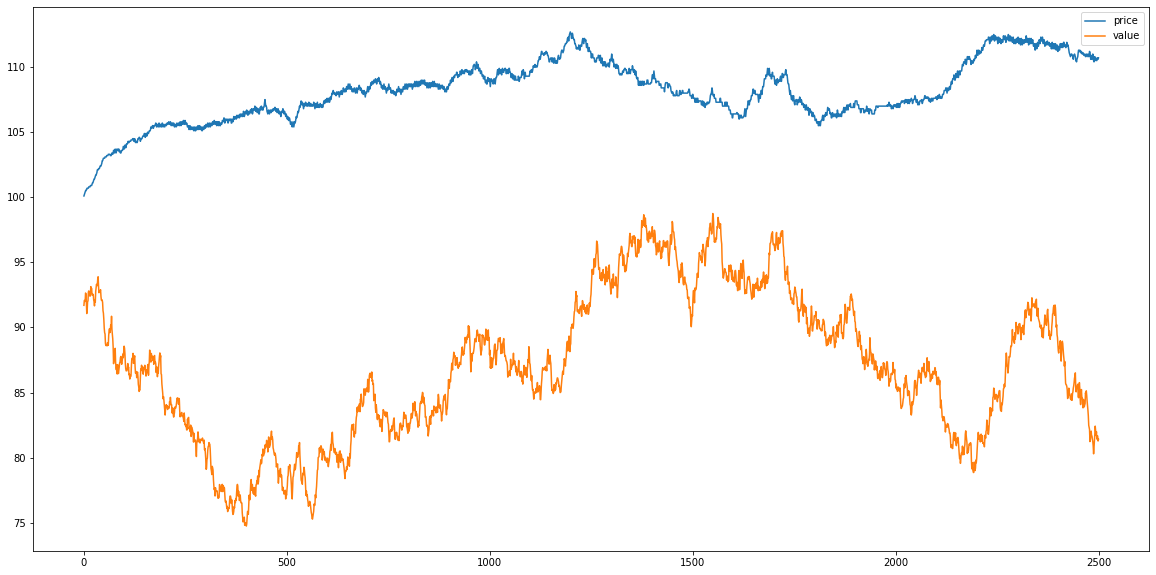

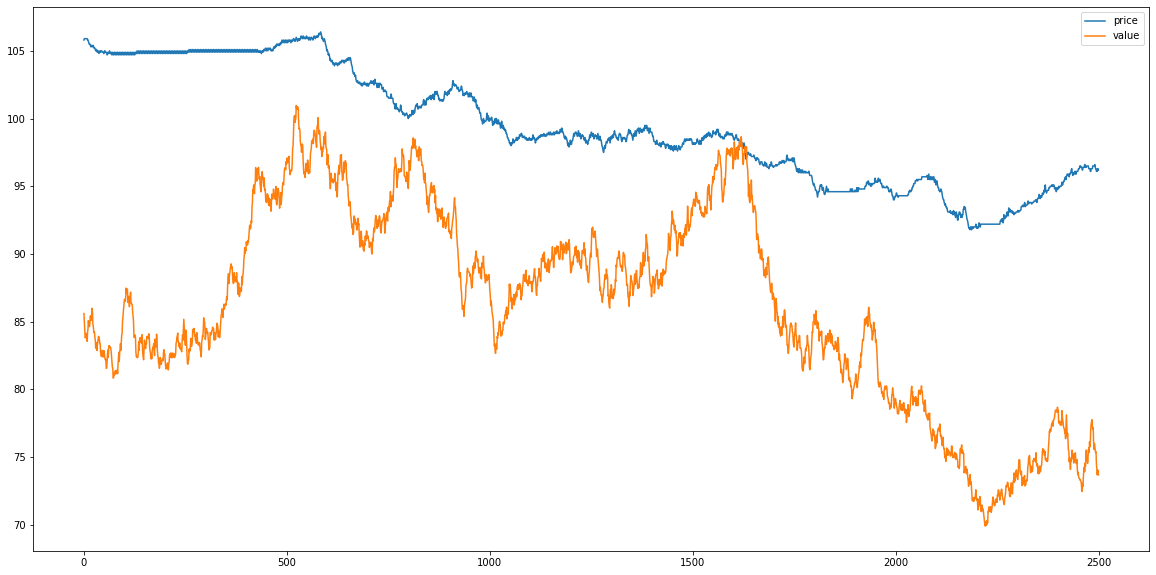

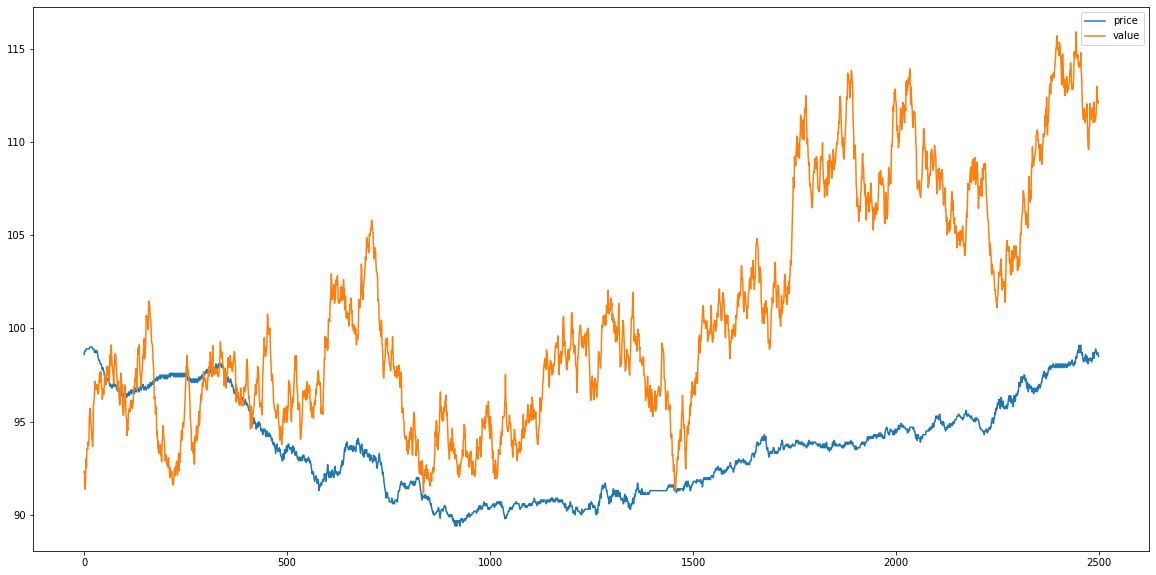

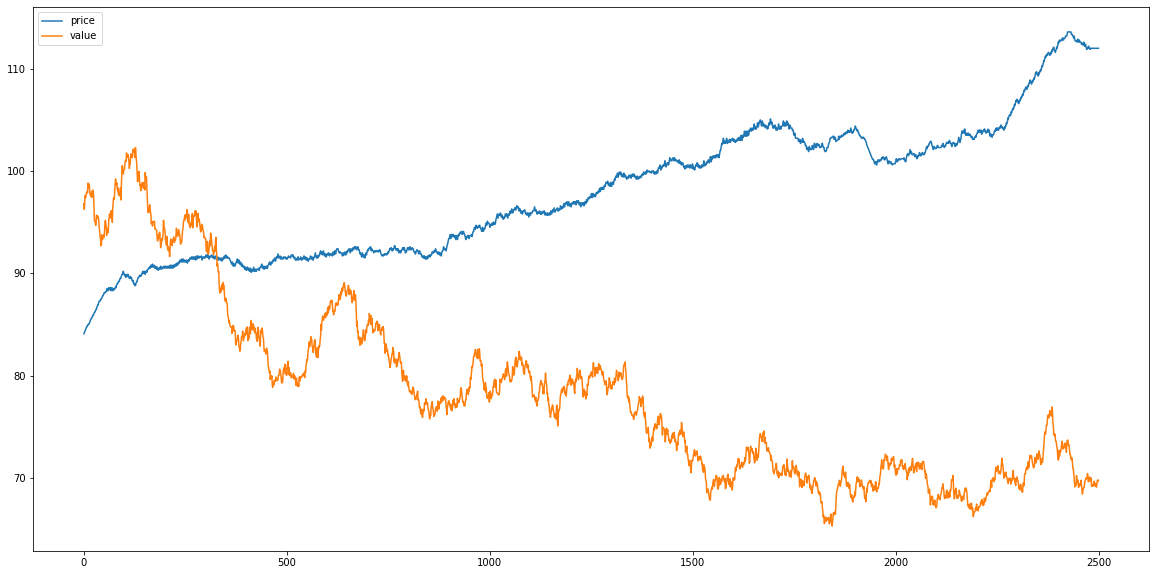

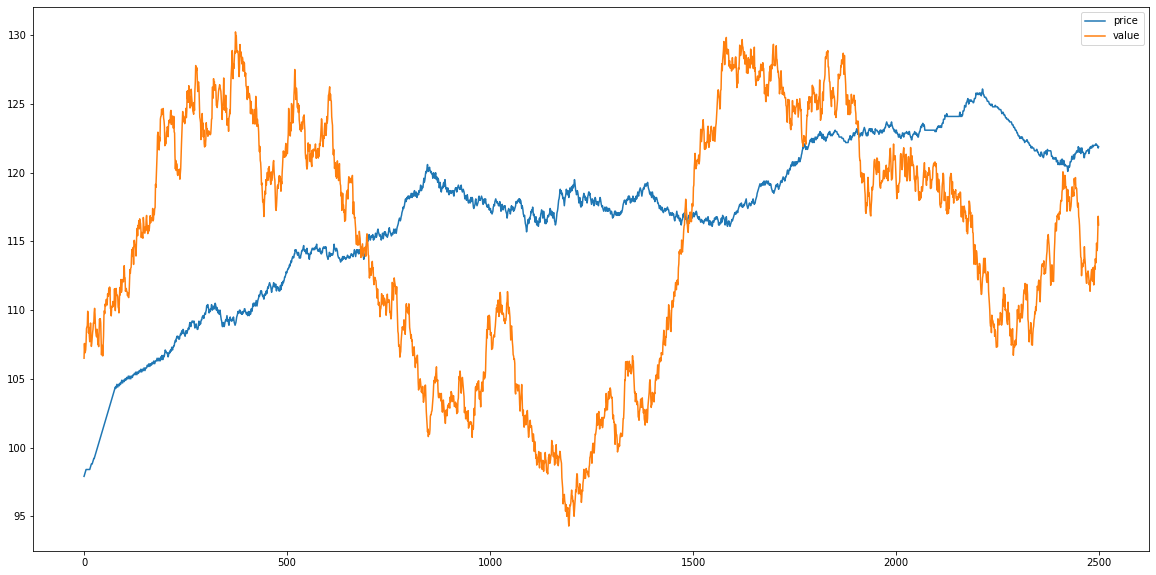

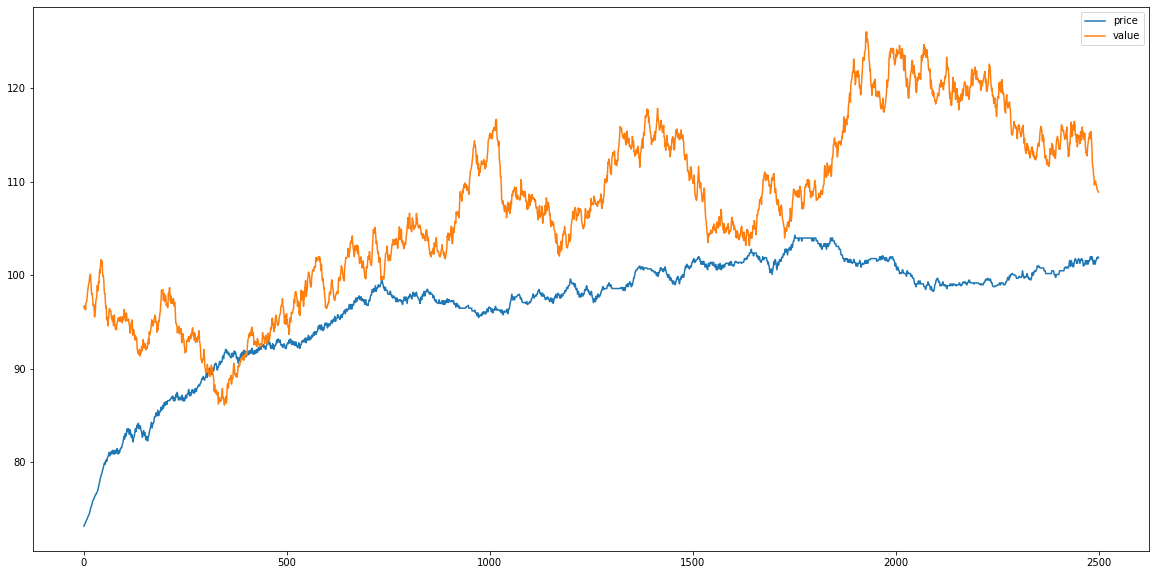

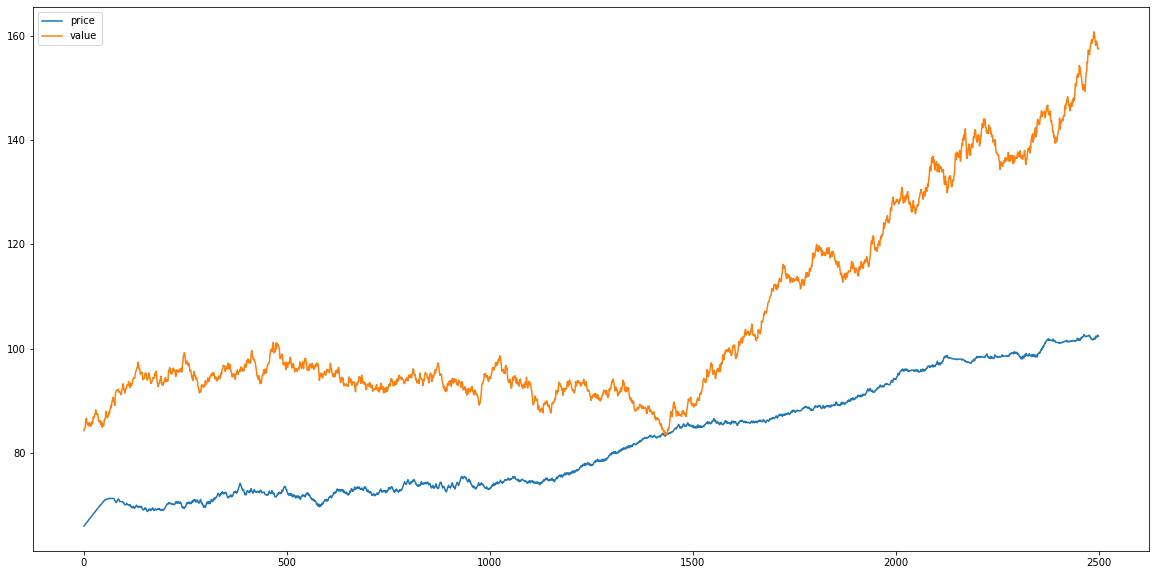

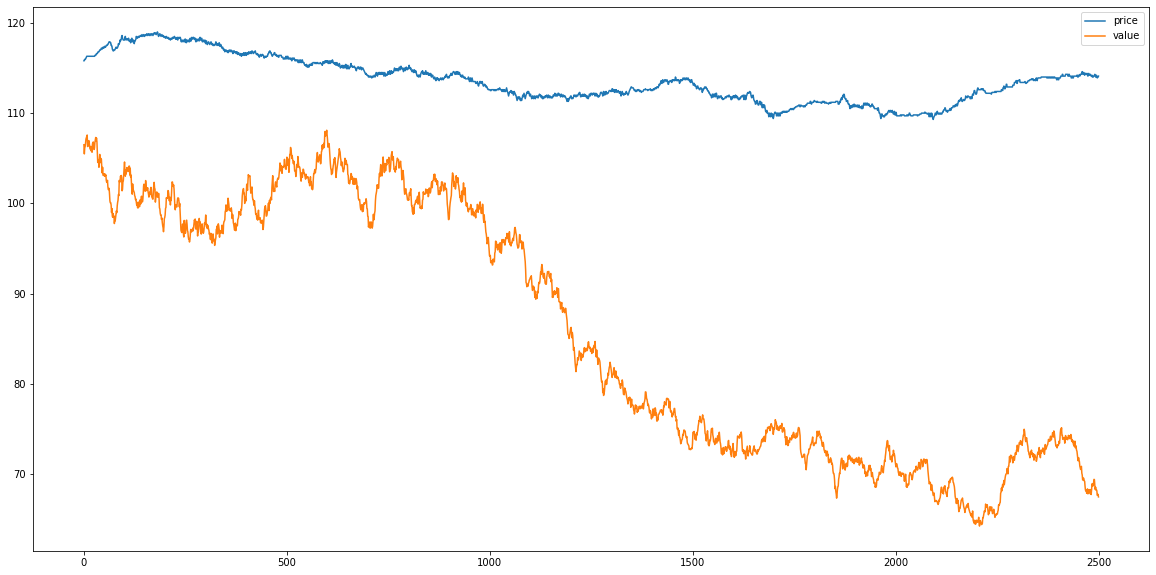

In [507]:
for market in markets:
    plt.plot(market['price'][250:], label = 'price')
    plt.plot(market['value'][250:], label = 'value')
    plt.legend()
    plt.show()


### Bid & Ask

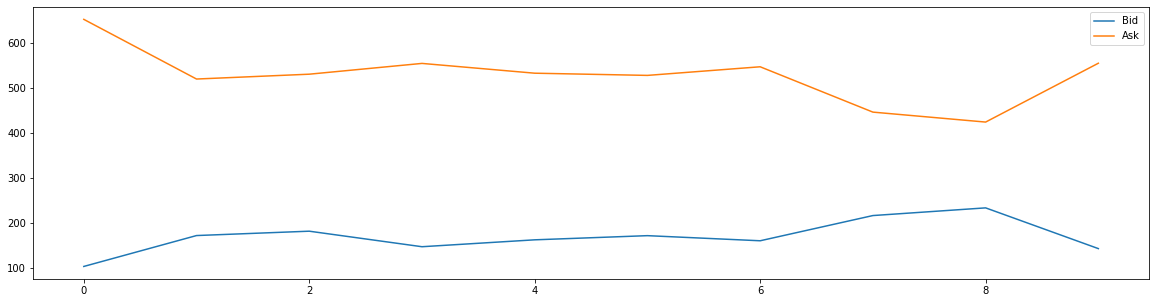

Average step per bid quantity per agent: 2.963470133436763
Average step per ask quantity per agent: 0.9442242219800141


In [748]:
avg_bids, avg_asks = [], []
for market in markets:
    avg_bids.append(sum(market['bid']) / len(market['bid']))
    avg_asks.append(sum(market['ask']) / len(market['ask']))

plt.plot(avg_bids, label = 'Bid')
plt.plot(avg_asks, label = 'Ask')
plt.legend()
plt.show()
print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / num_agent)}")
print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / num_agent)}")

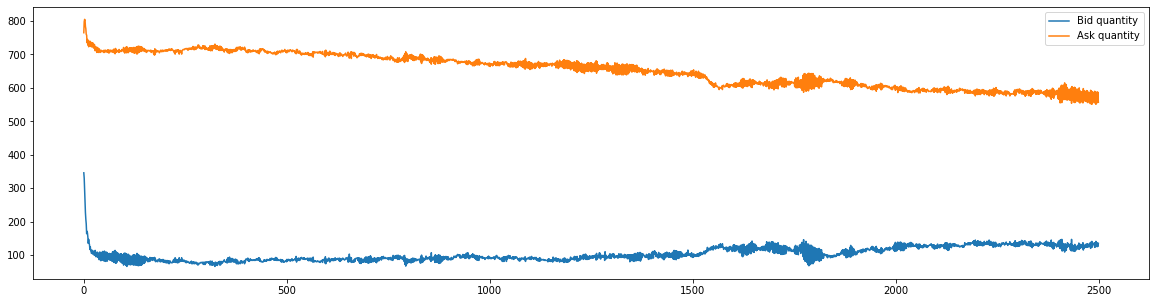

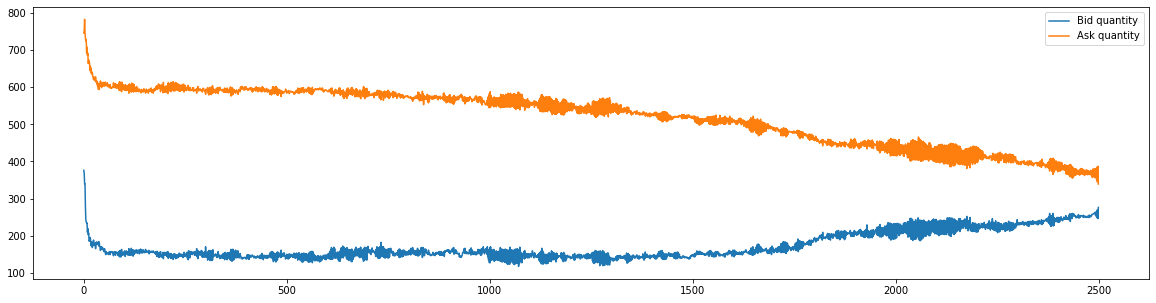

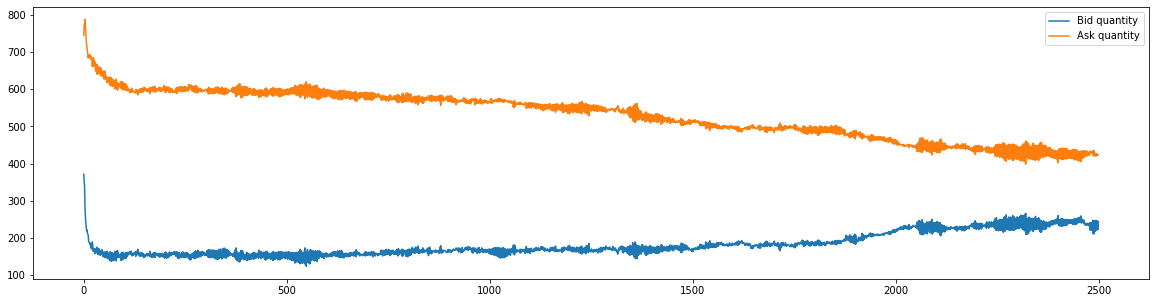

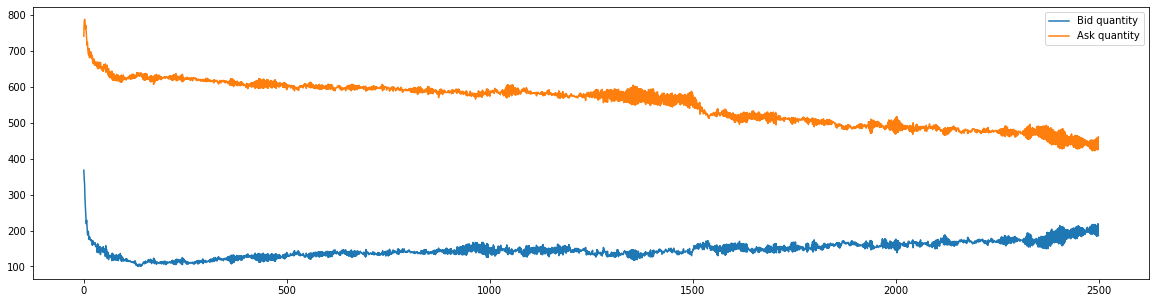

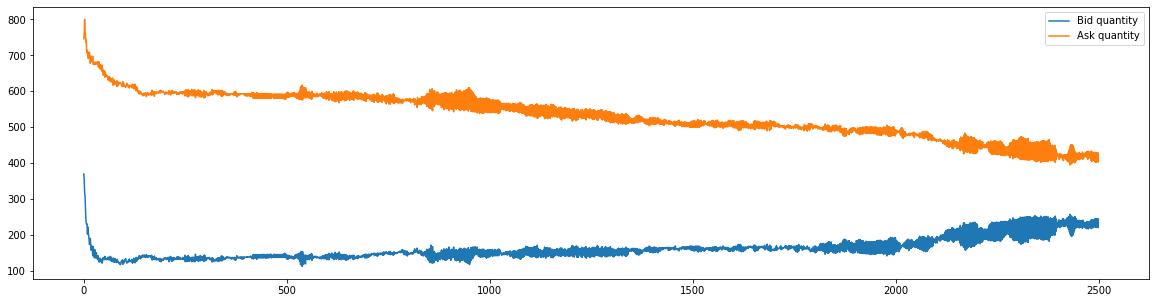

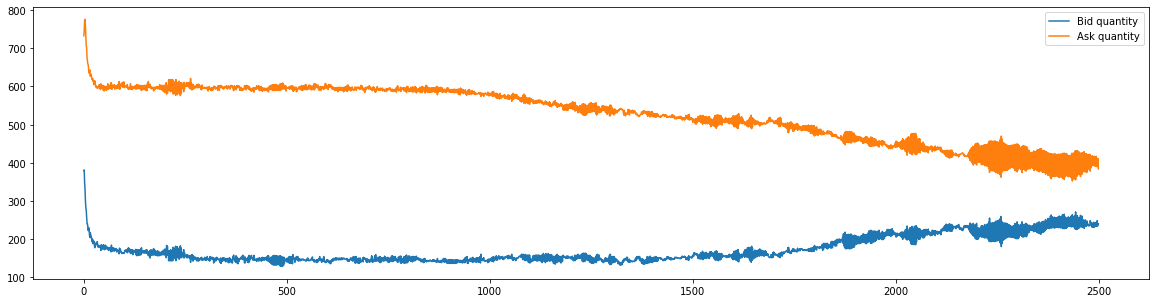

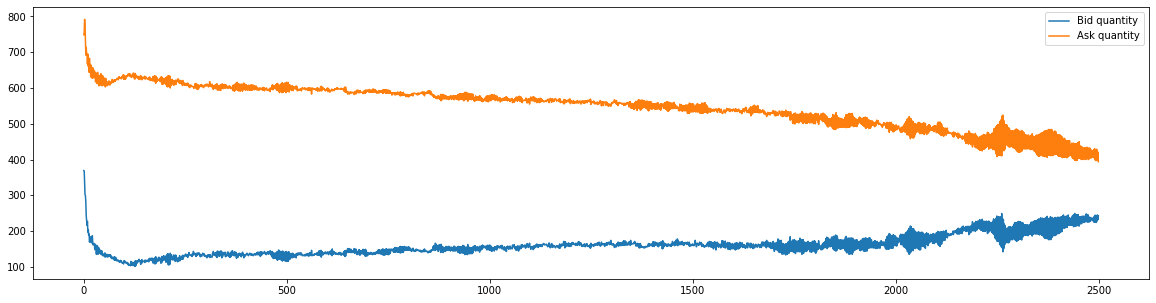

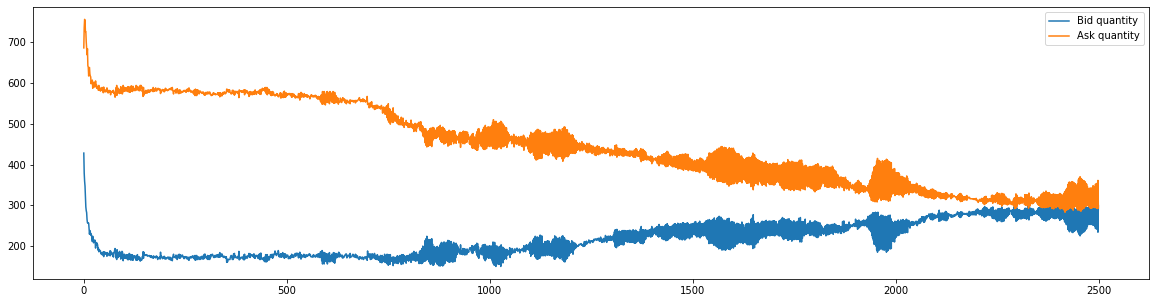

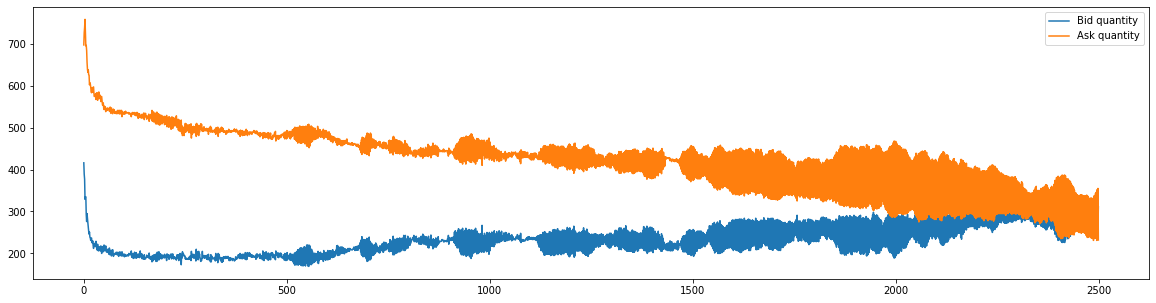

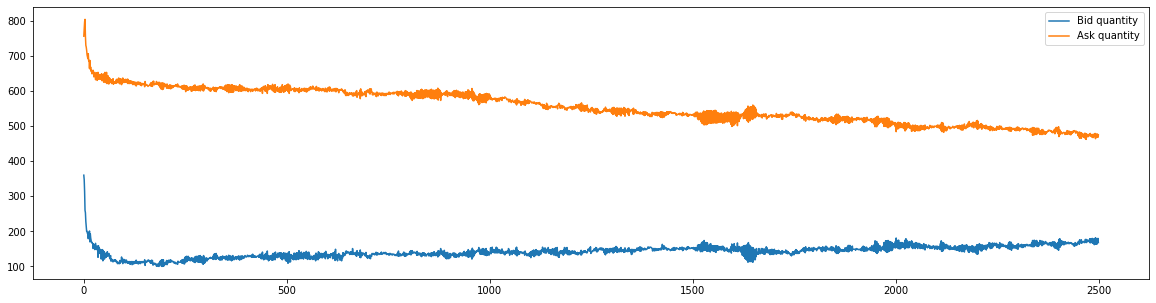

In [747]:
for market in markets:
    plt.plot(market['bid'], label = 'Bid quantity')
    plt.plot(market['ask'], label = 'Ask quantity')
    plt.legend()
    plt.show()

### Agent returns

#### Distribution of total returns 

In [512]:
all_agent_returns = []
for rl_state in rl_states:
    for agent_state in rl_state.values():
        returns = (agent_state['states'][-1]['wealth'] - agent_state['states'][0]['wealth']) / agent_state['states'][0]['wealth']
        all_agent_returns.append(round(returns * 100))

In [513]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])

Rate of positive returns: 0.988358089120835
Rate of negtive returns: 0.011641910879164994


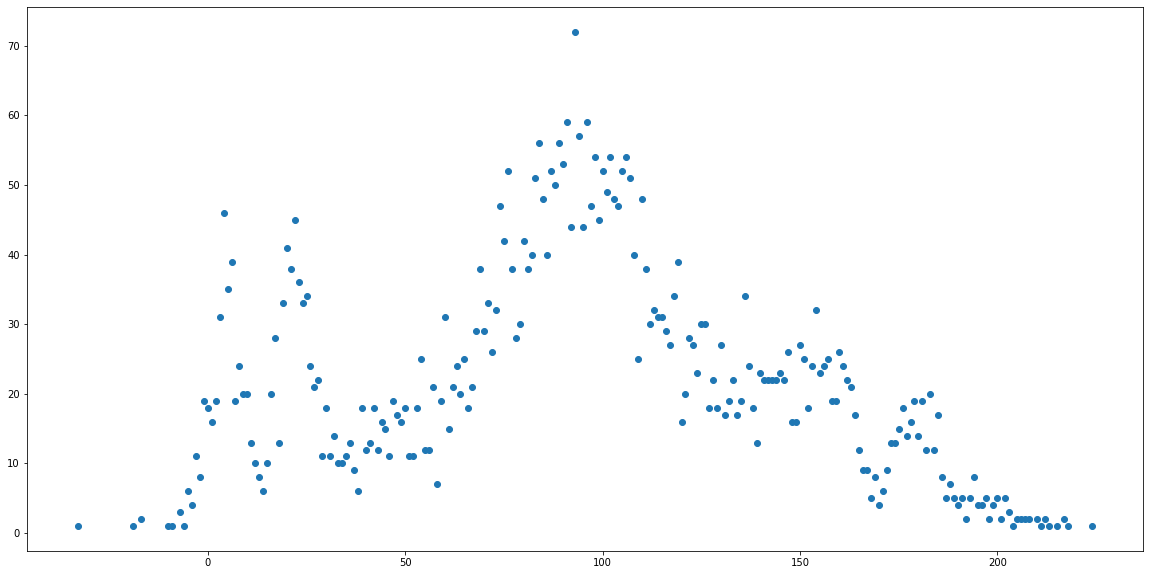

In [514]:
num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
agent_returns_counter = Counter(all_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)
print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")

#### Distribution of returns by agent

In [515]:
agent_ids = rl_states[0].keys()
agent_returns = {agent_id: [] for agent_id in agent_ids}

for rl_state in rl_states:
    for agent_id, agent_state in rl_state.items():
        returns = (agent_state['states'][-1]['wealth'] - agent_state['states'][0]['wealth']) / agent_state['states'][0]['wealth']
        agent_returns[agent_id].append(round(returns * 100, 2))

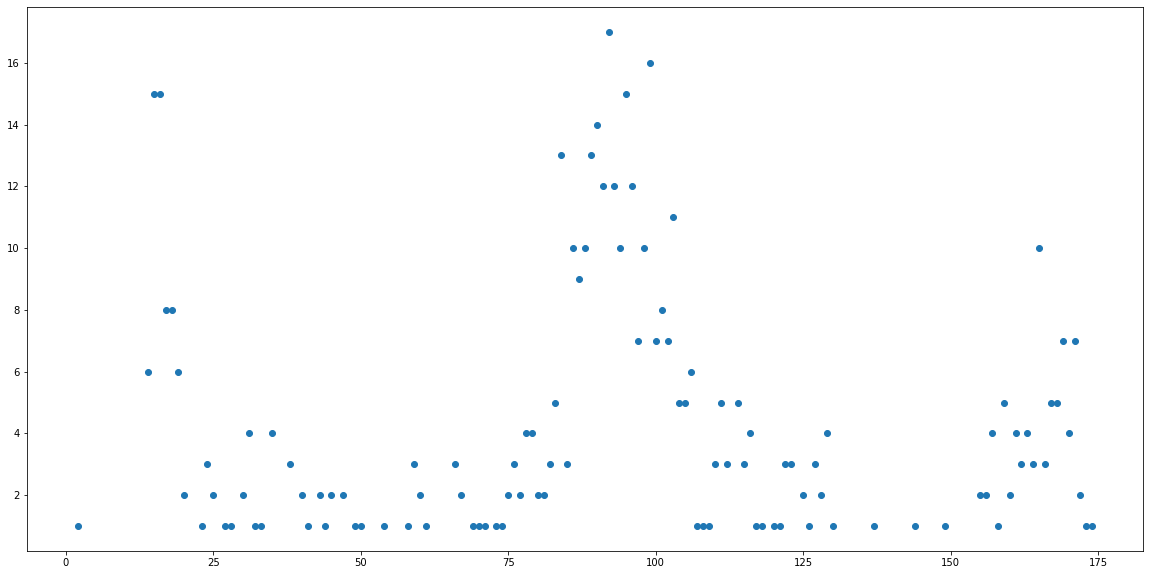

In [516]:
avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
agent_returns_counter = Counter(avg_agent_returns)
returns_x = sorted(agent_returns_counter.keys())
returns_y = [agent_returns_counter[x] for x in returns_x]
plt.scatter(returns_x, returns_y)

Positive progress: 0.558
Negative progress: 0.442


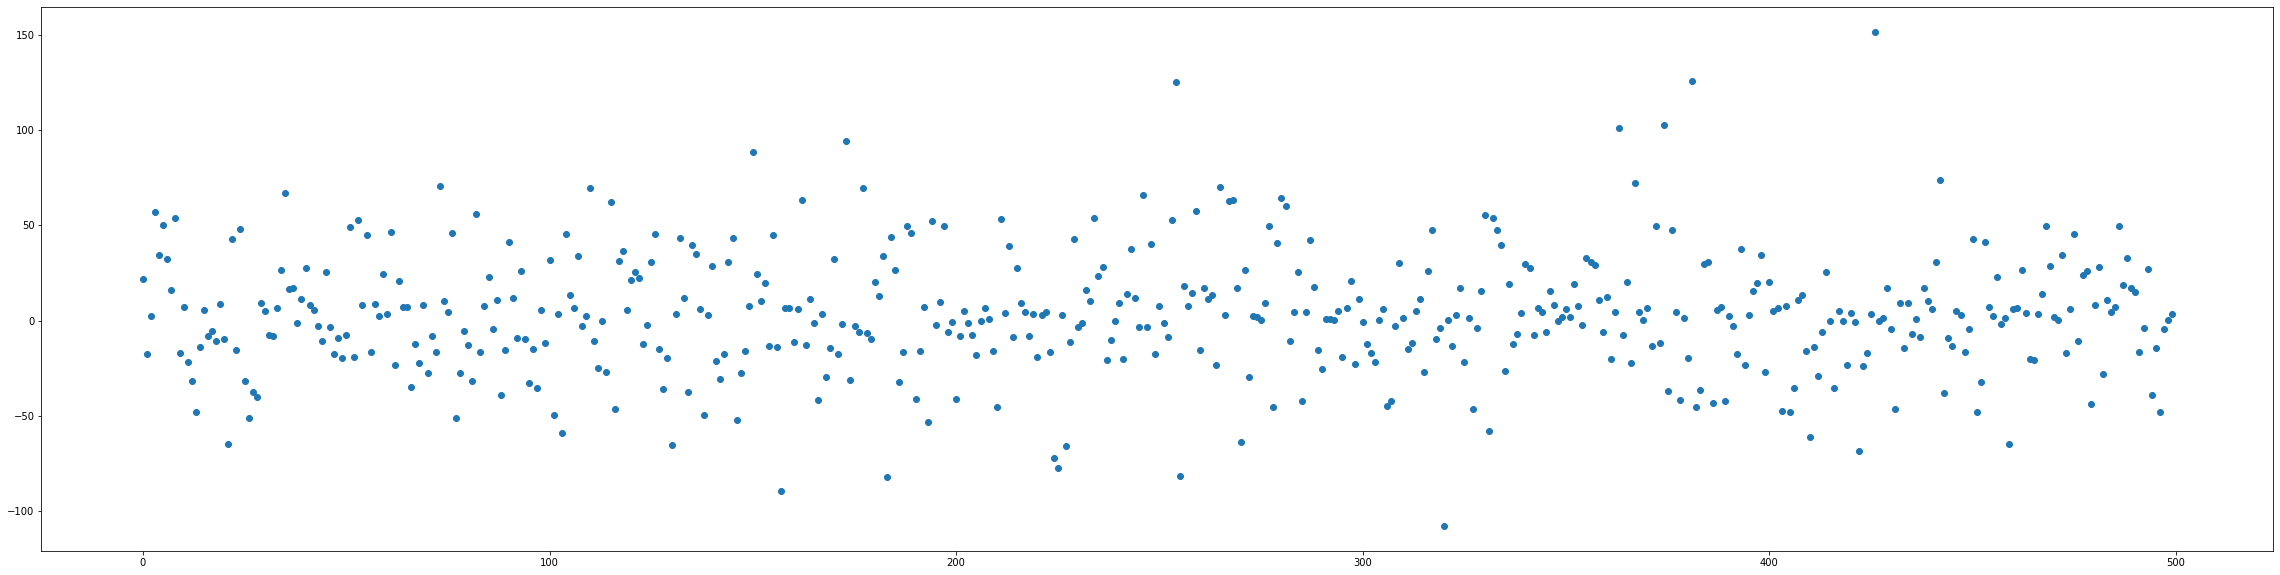

In [517]:
plt.figure(figsize=(40, 10))
returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
plt.scatter(list(range(len(returns_progress))), returns_progress)
num_pos_progress = len([progress for progress in returns_progress if progress > 0])
num_neg_progress = len([progress for progress in returns_progress if progress < 0])
print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
print(f"Negative progress: {num_neg_progress / len(returns_progress)}")


### Action rate

In [583]:
group_names = list(agents[0].keys())
group_names

['ppo_tr_250', 'ppo_va_250']

In [658]:
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
agent_actions = {"BID": 0, "ASK": 0, "HOLD": 0}
agent_ticks = defaultdict(int)
agent_volume = defaultdict(int)
group_names = list(agents[0].keys())
group_agent_actions = {group_name: {"BID": 0, "ASK": 0, "HOLD": 0} for group_name in group_names}
for state in rl_states:
    for agent_id, agent in state.items():
        for group_name in group_names:
            if agent_id.startswith(group_name):
                break
        for action in agent['actions']:
            trade_action = action_ref[action[0]]
            tick = tick_ref[action[1]]
            volume = action[2] + 1
            group_agent_actions[group_name][trade_action] += 1
            agent_actions[trade_action] += 1
            agent_ticks[tick] += 1
            agent_volume[volume] += 1
total_actions = sum(agent_actions.values())
print(f"Total action rate\nBid: {agent_actions['BID'] / total_actions} Ask: {agent_actions['ASK'] / total_actions} Hold: {agent_actions['HOLD'] / total_actions}")
print(f"Group action rate")
for group_name in group_names:
    group_total_actions = total_actions / len(group_names)
    print(f"{group_name}, Bid: {group_agent_actions[group_name]['BID'] / group_total_actions} Ask: {group_agent_actions[group_name]['ASK'] / group_total_actions} Hold: {group_agent_actions[group_name]['HOLD'] / group_total_actions}")





Total action rate
Bid: 0.26729464 Ask: 0.32733192 Hold: 0.40537344
Group action rate
ppo_tr_250, Bid: 0.22912 Ask: 0.30552416 Hold: 0.46535584
ppo_va_250, Bid: 0.30546928 Ask: 0.34913968 Hold: 0.34539104


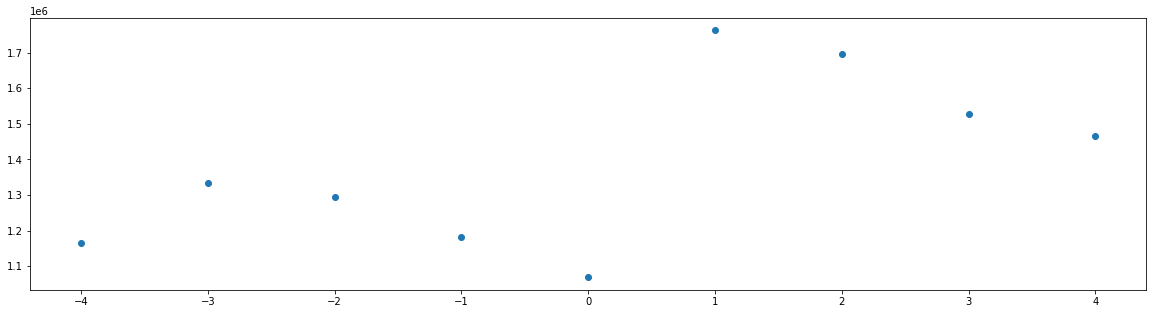

In [665]:
ticks = sorted(list(agent_ticks.keys()))
plt.scatter(ticks, [agent_ticks[tick] for tick in ticks])

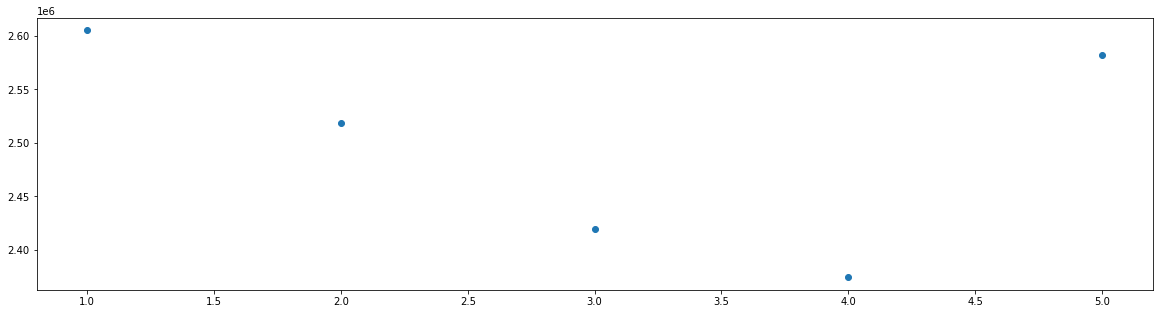

In [668]:
volumes = sorted(list(agent_volume.keys()))
plt.scatter(volumes, [agent_volume[volume] for volume in volumes])

### Sample agent

In [541]:
# sample agent to analyse
agent_id = random.sample(agent_ids, 1)[0]

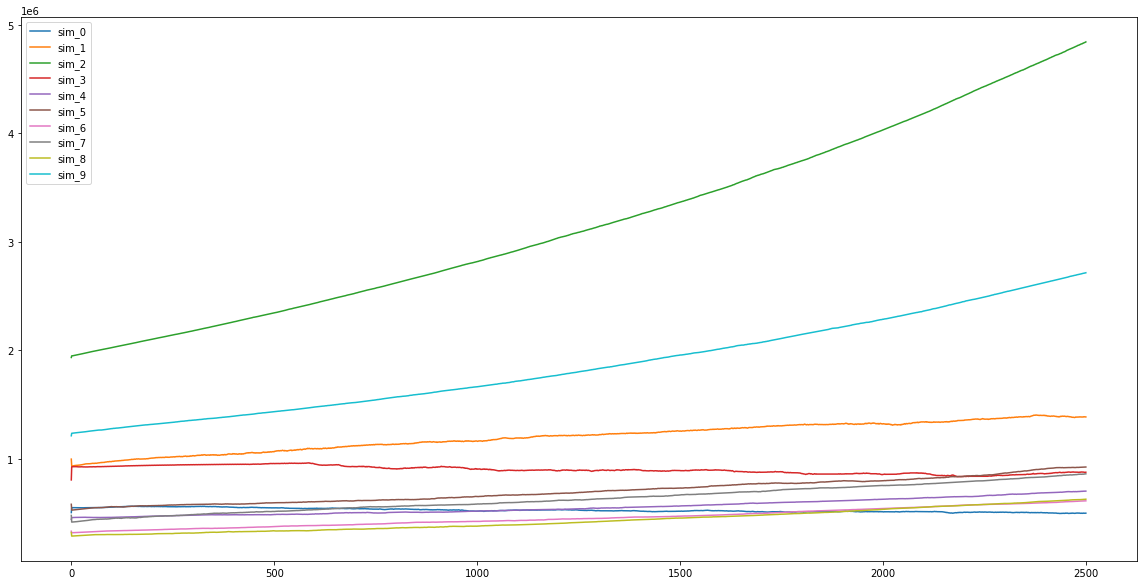

In [542]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()

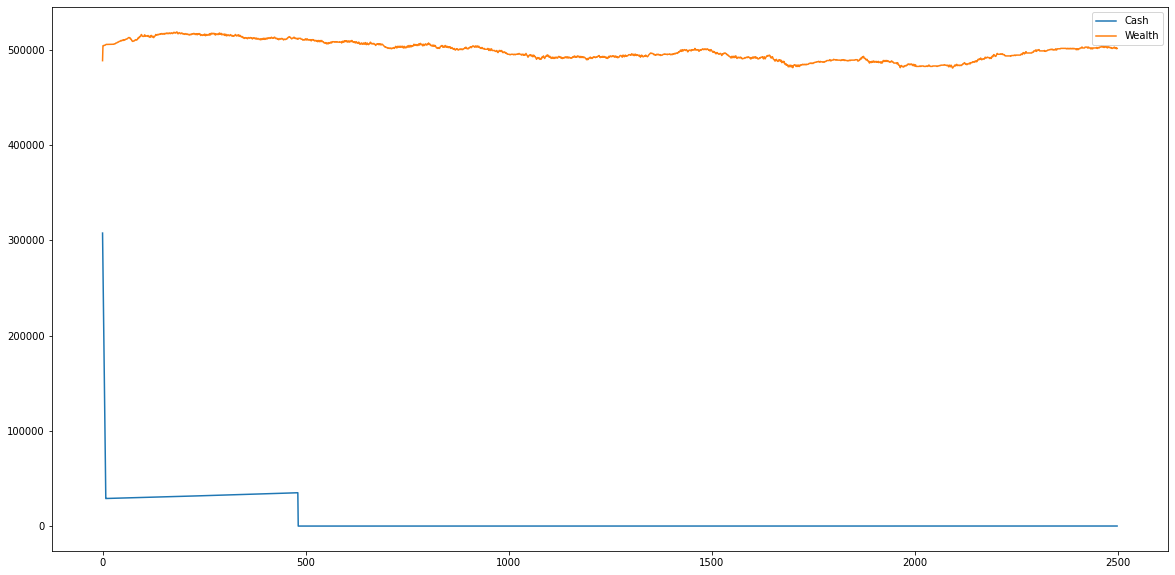

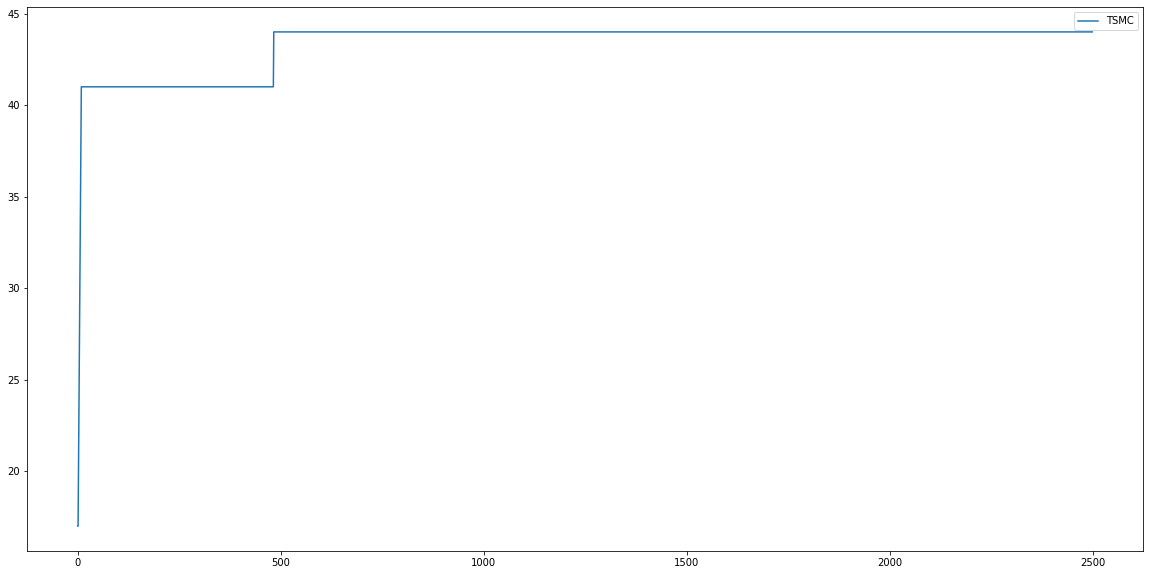

In [536]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

### Actions

In [753]:
value_group_name = "ppo_va_250"
value_agent_number = 250
value_agent_id = f"{value_group_name}_{random.randint(0, 249)}"
rl_state = rl_states[-1]
market = markets[-1]
tick_size = 0.1

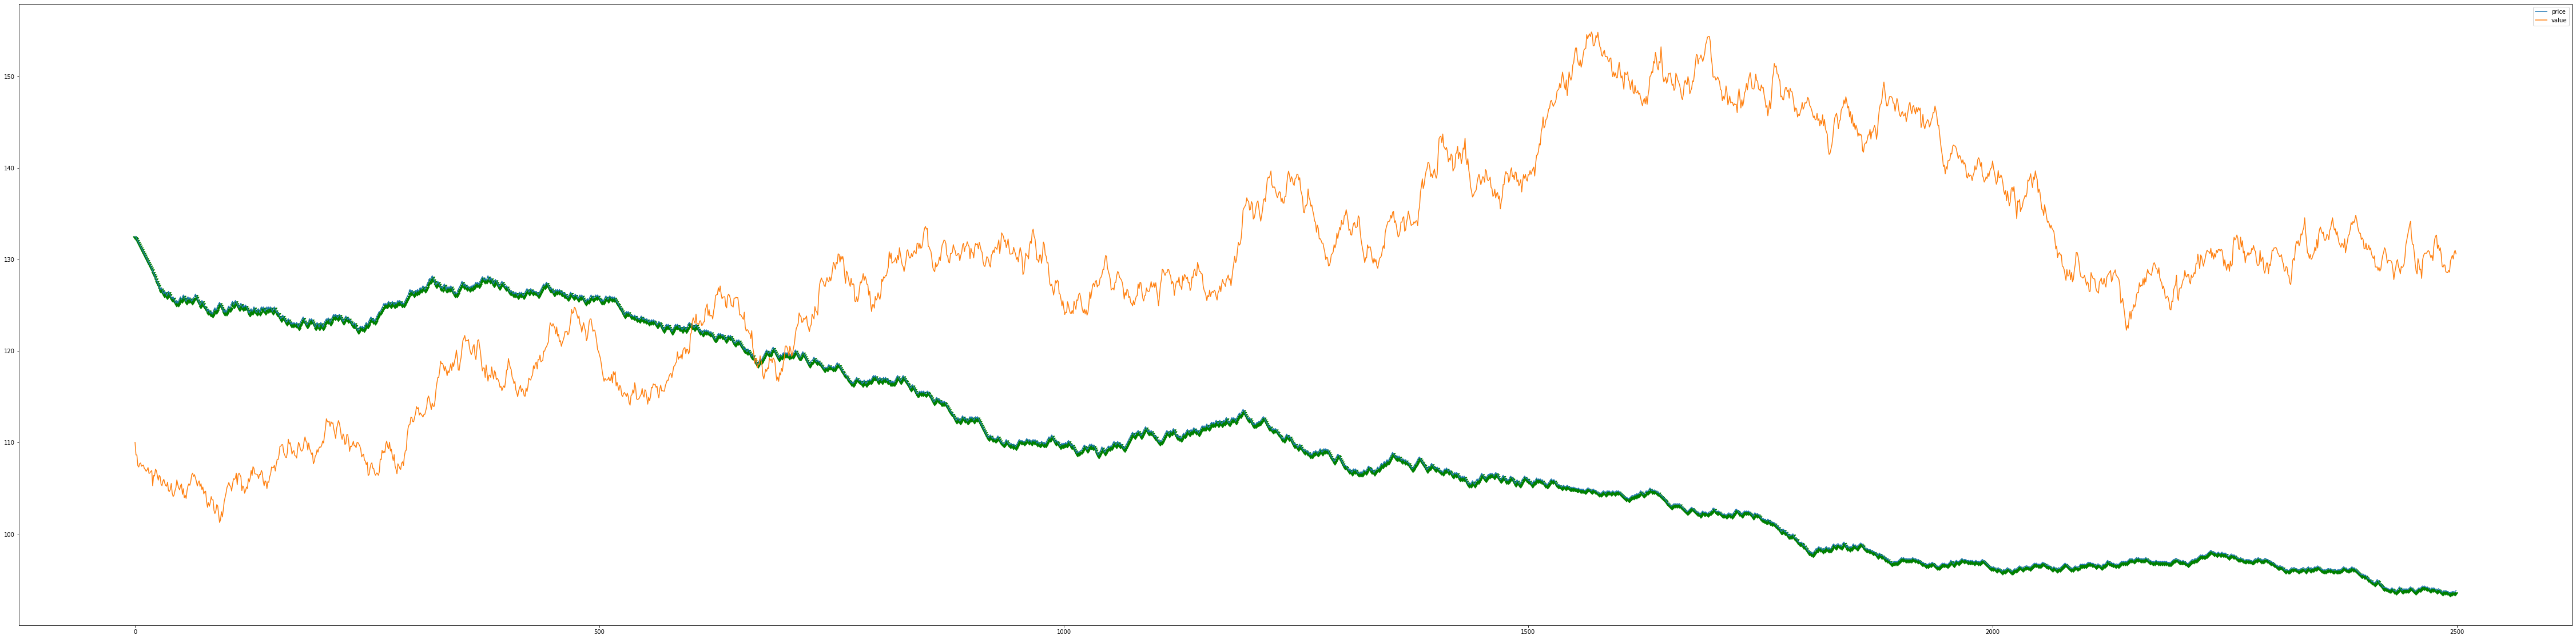

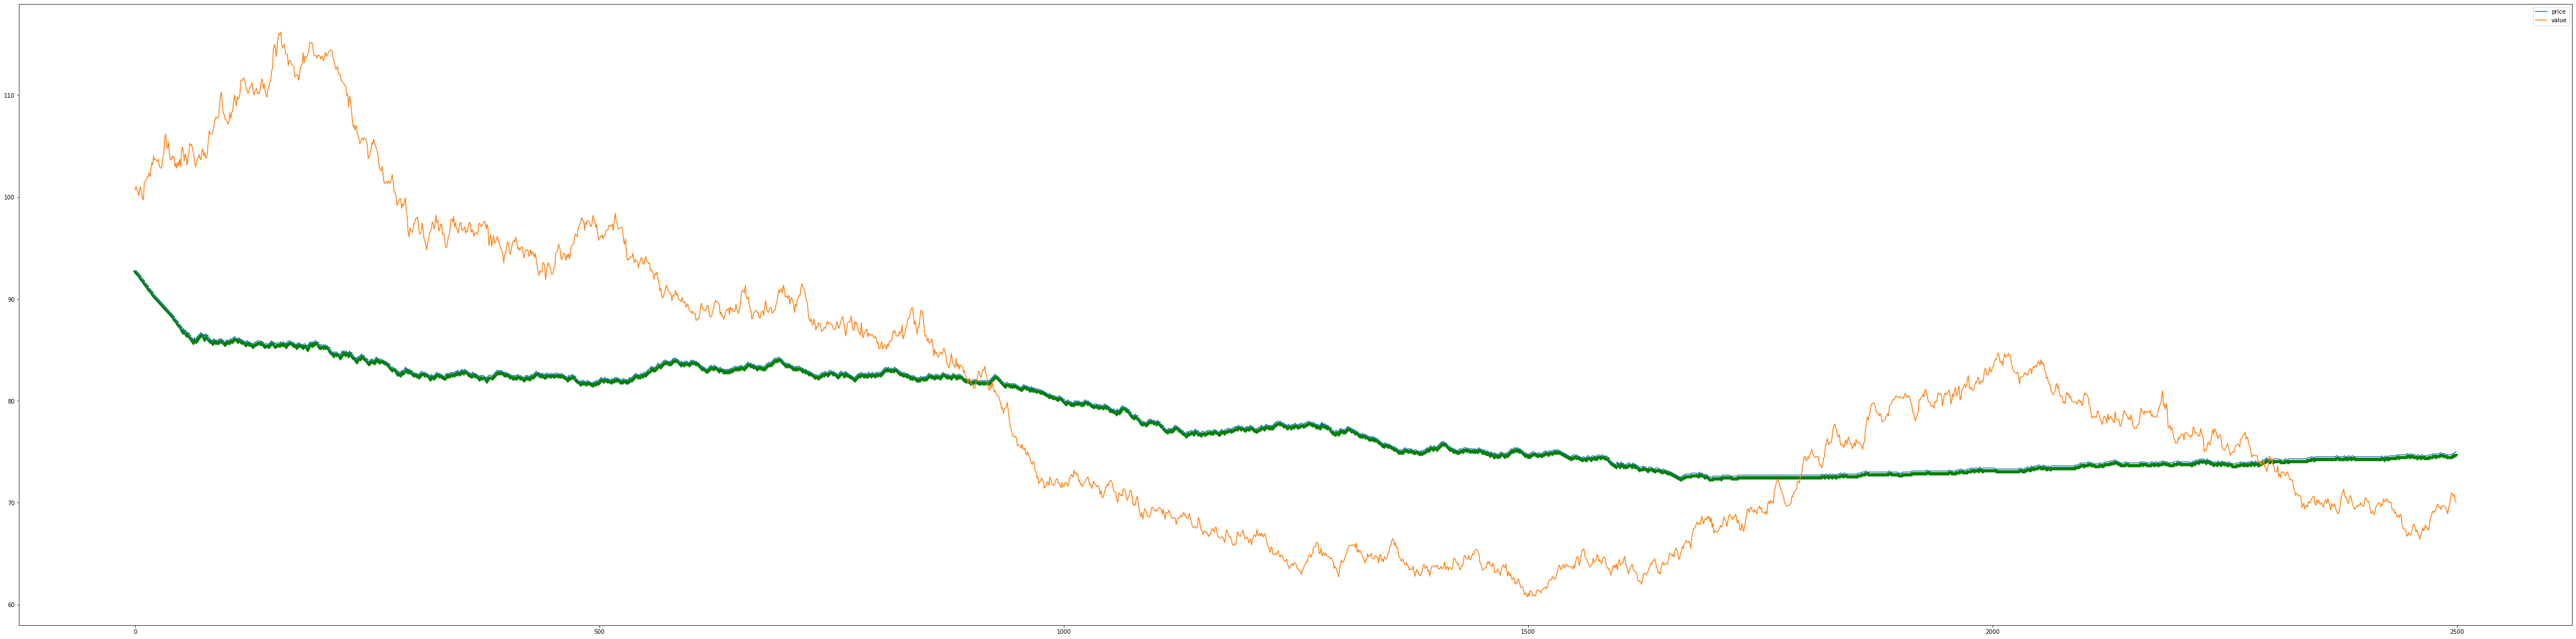

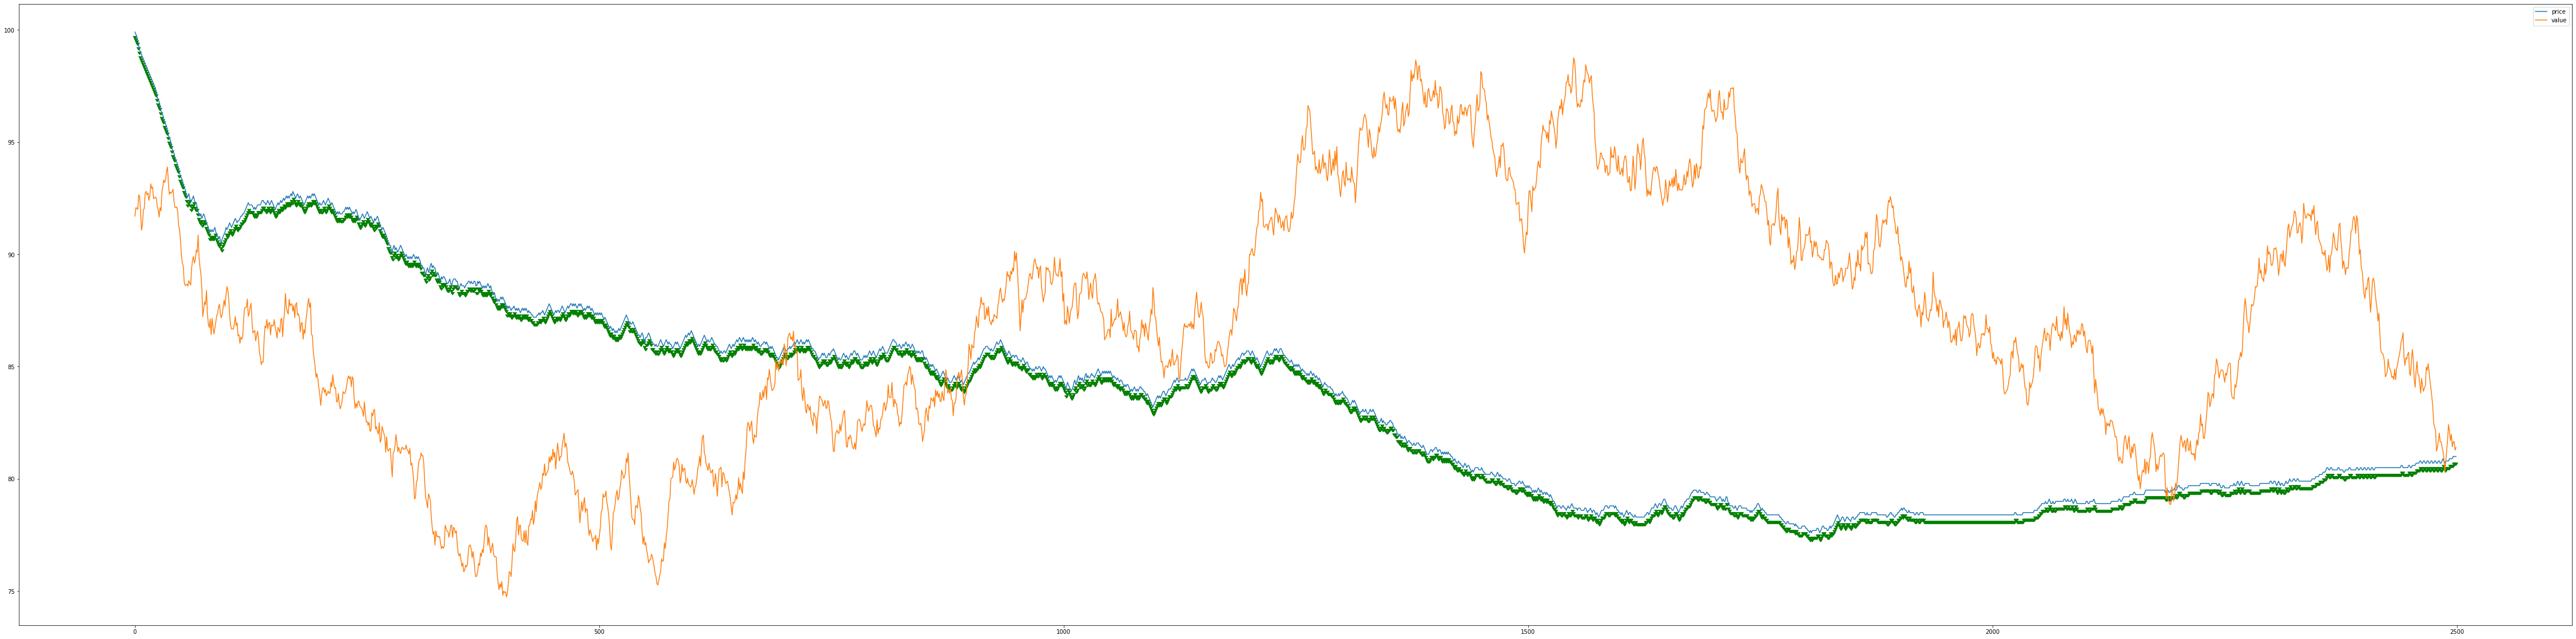

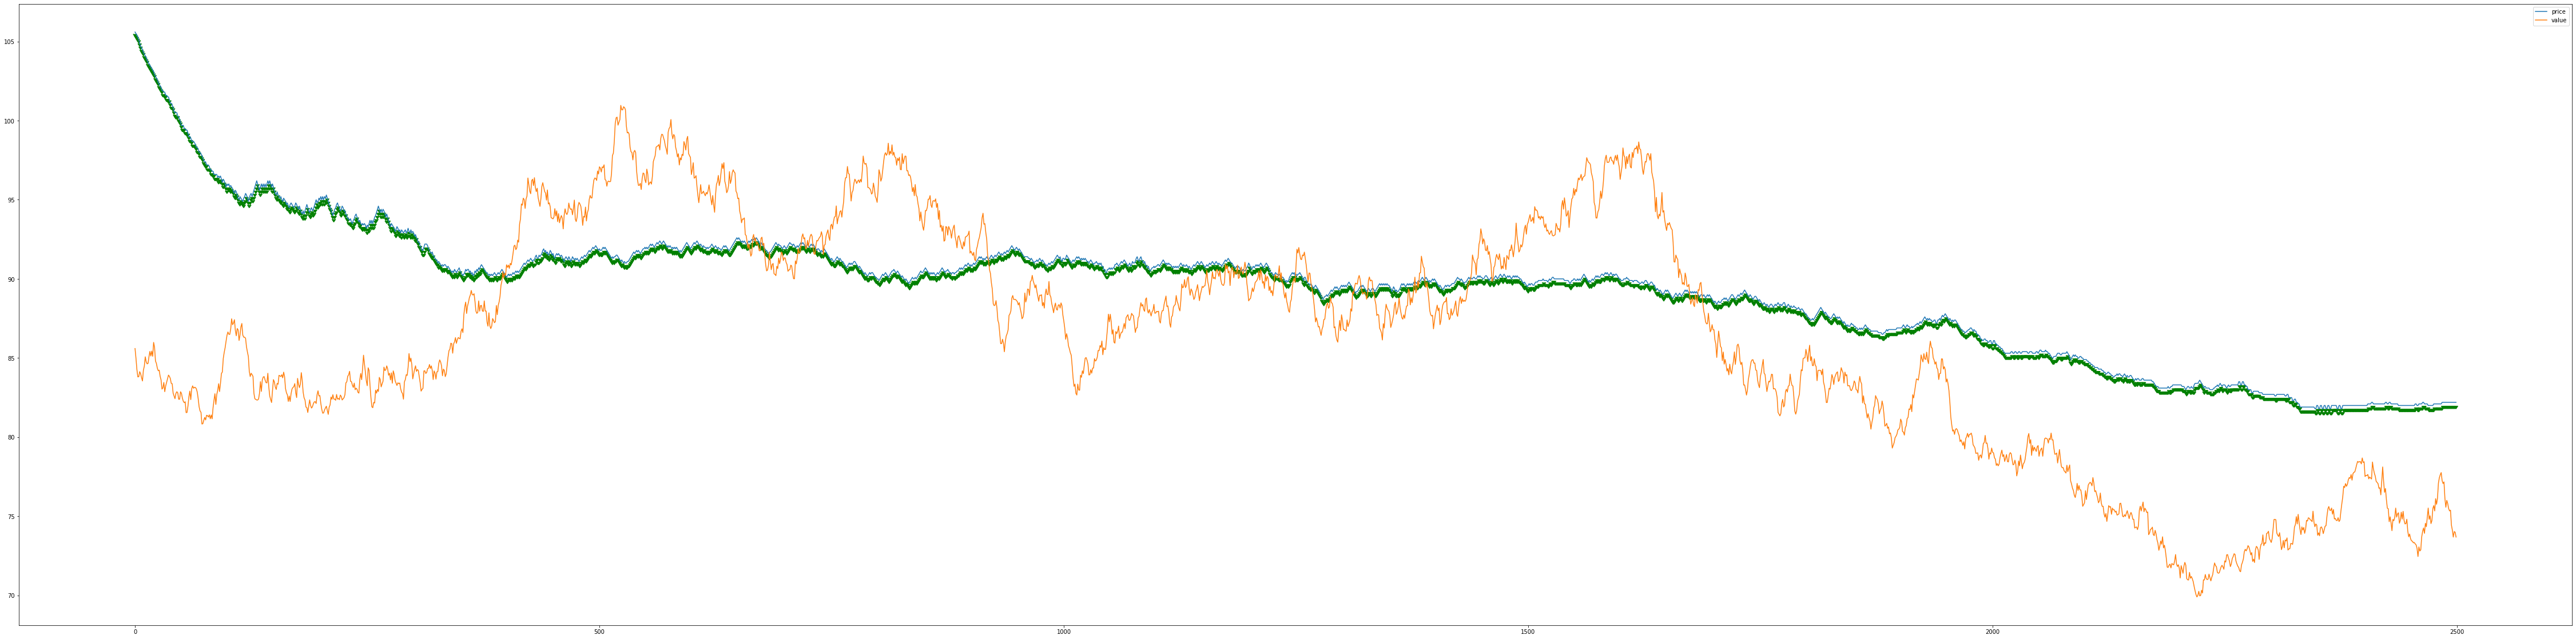

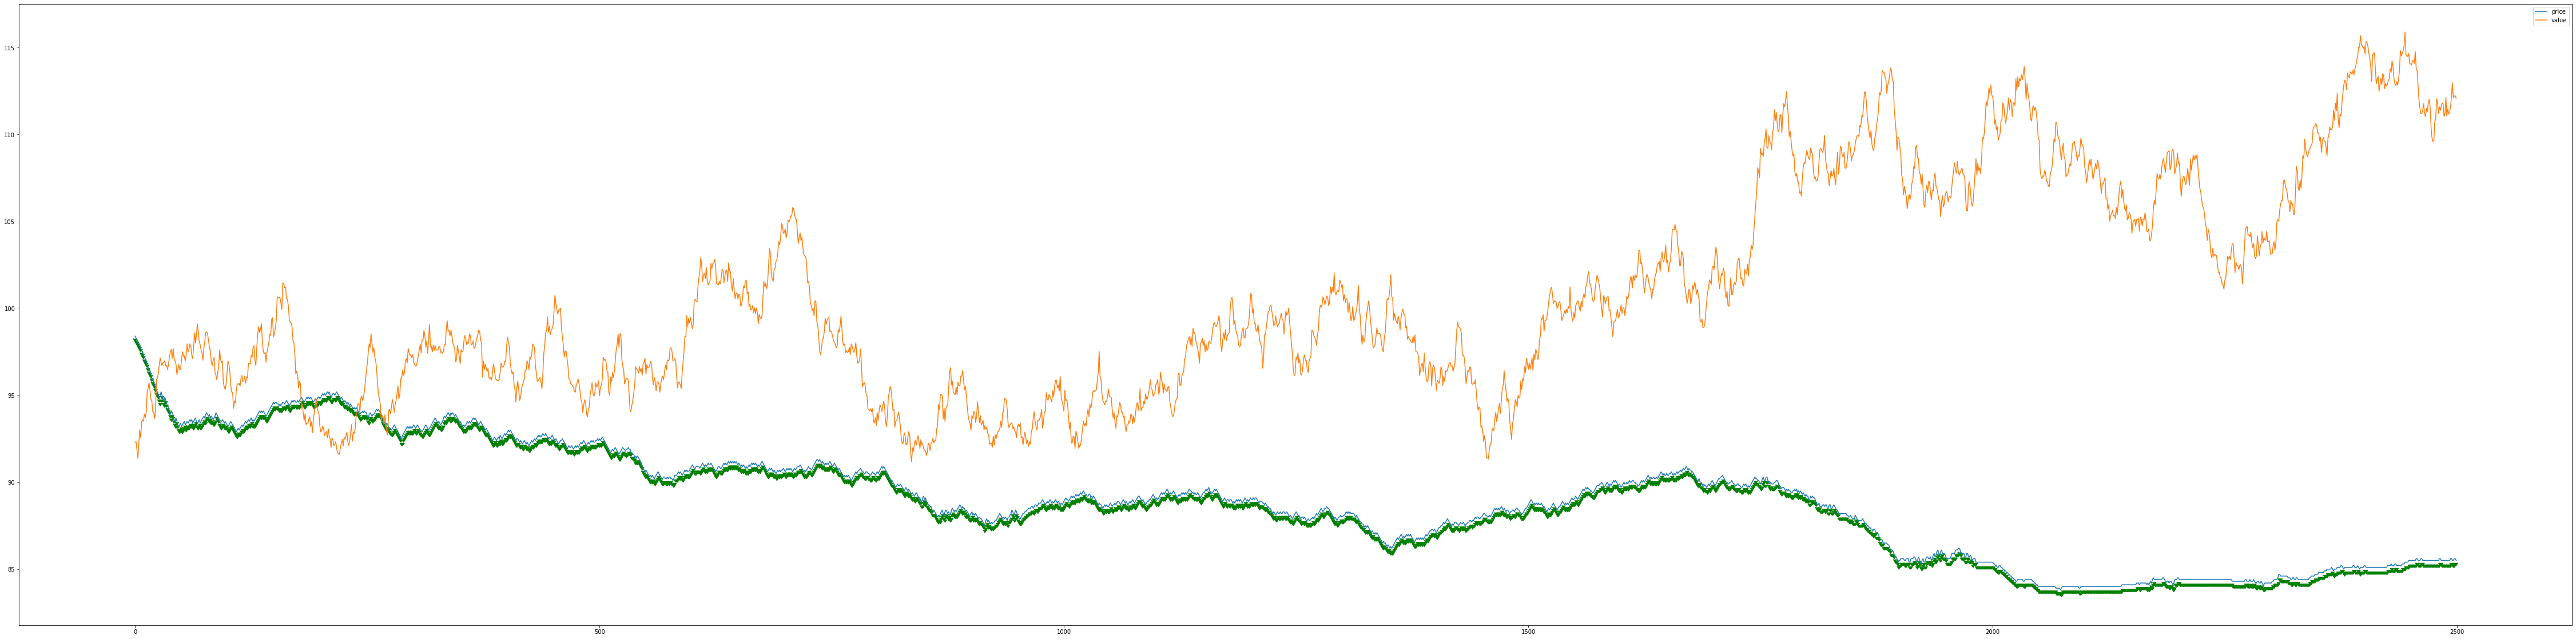

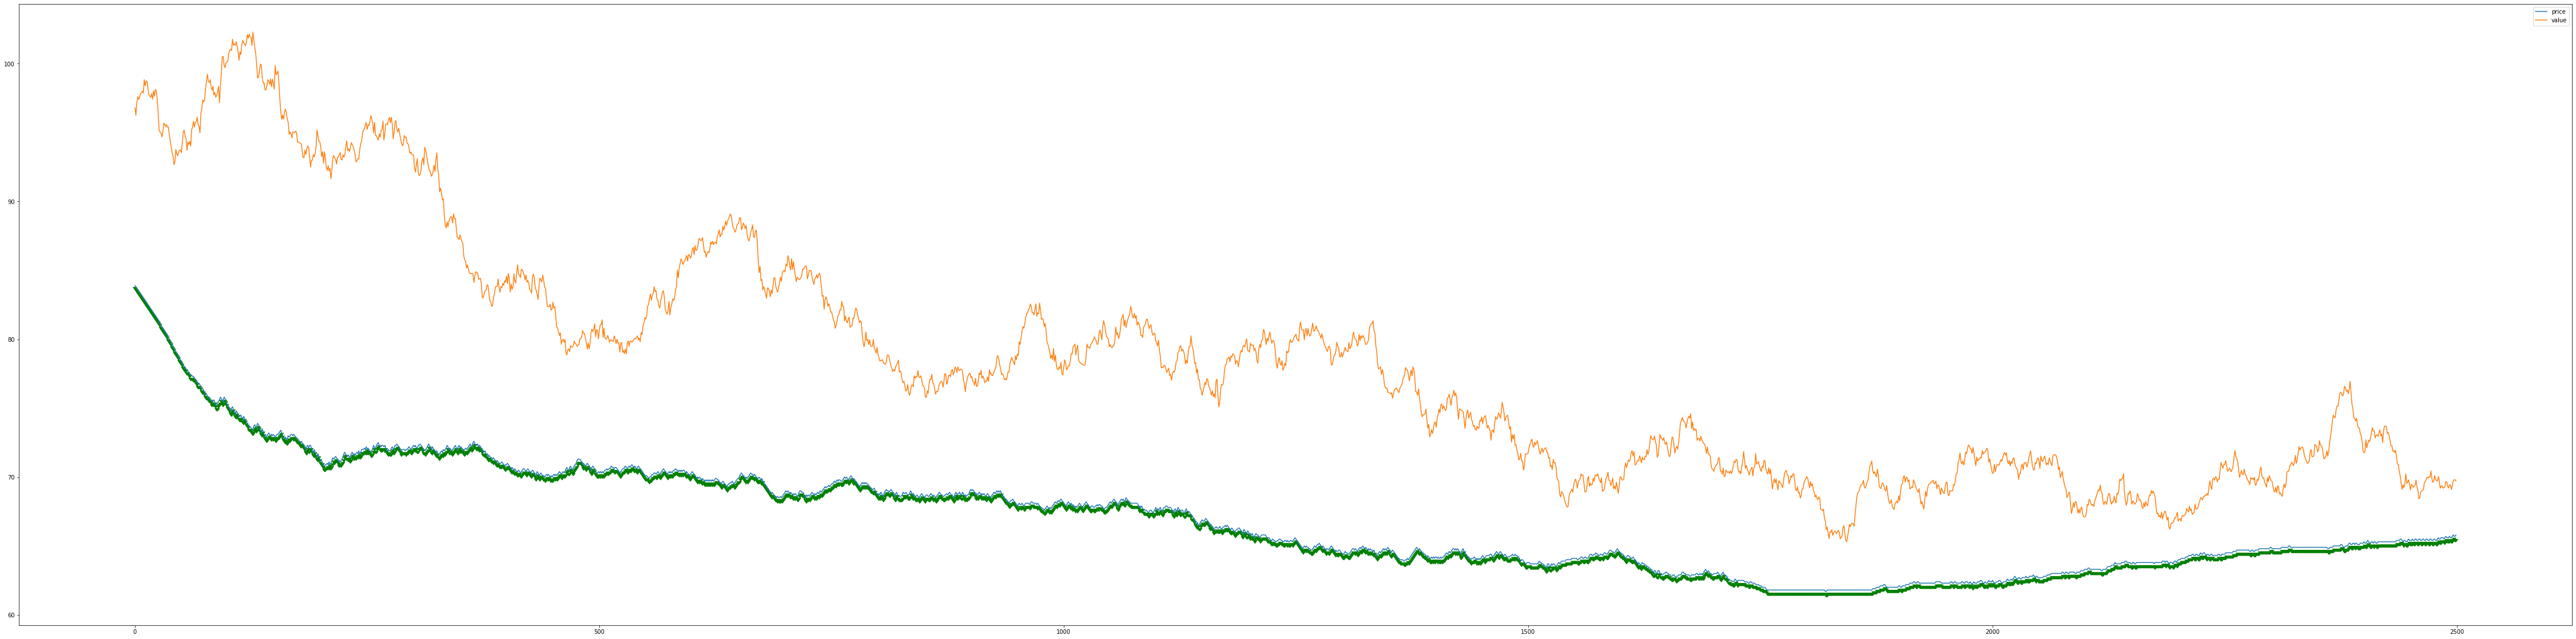

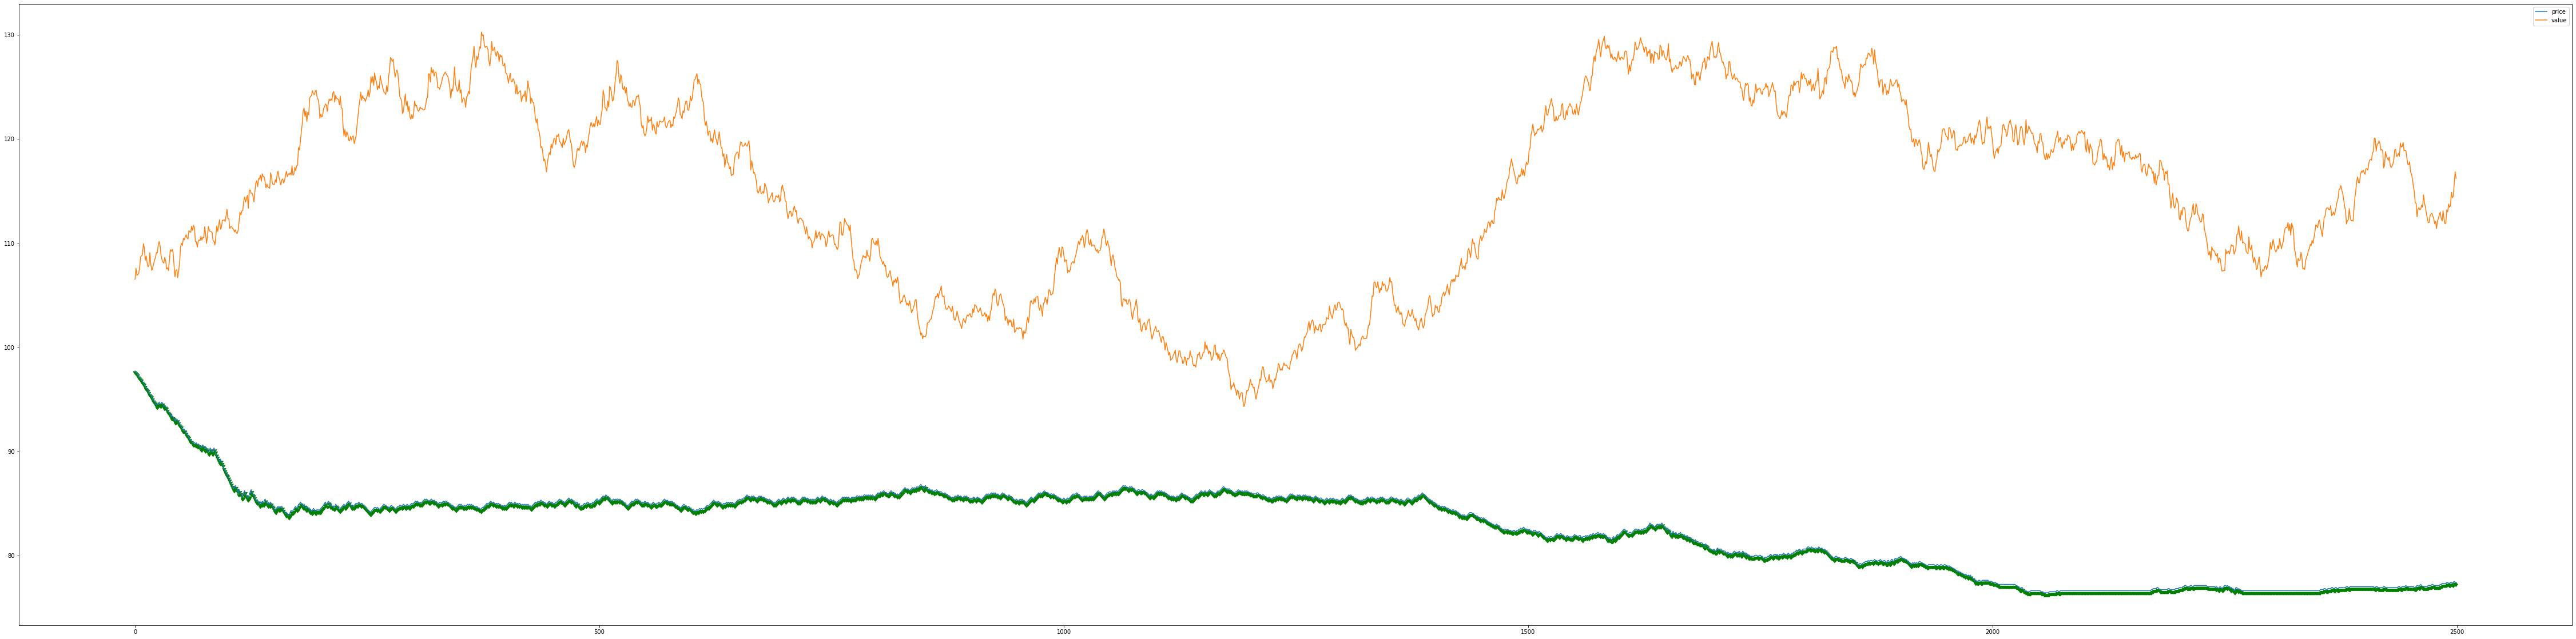

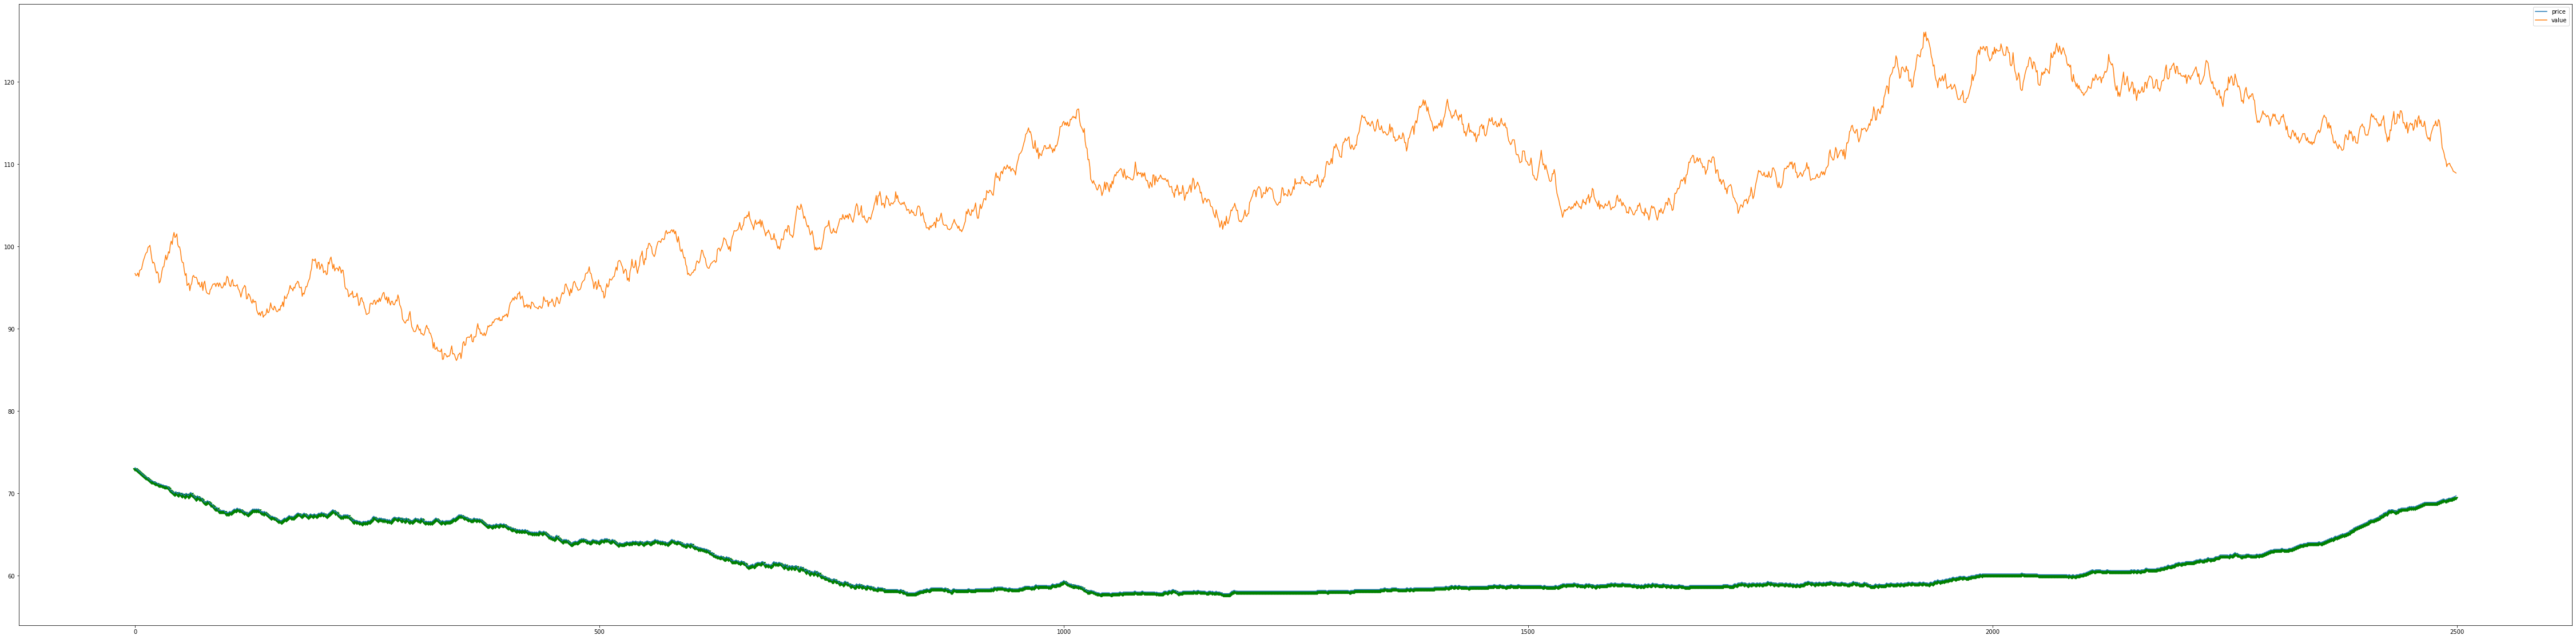

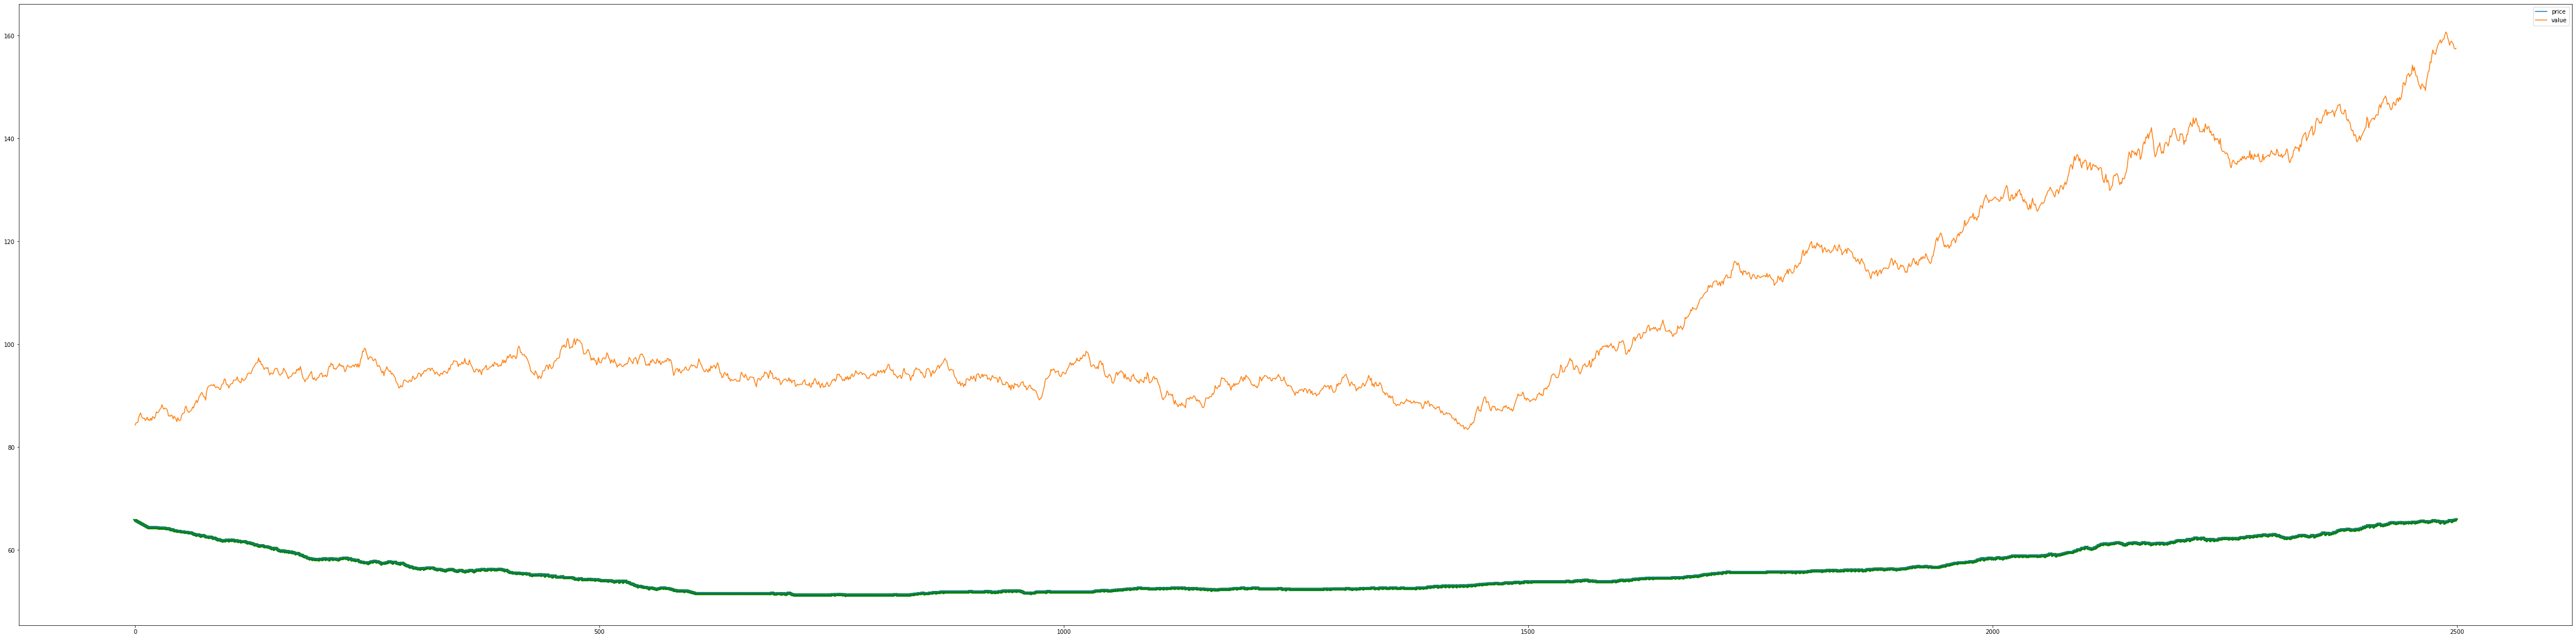

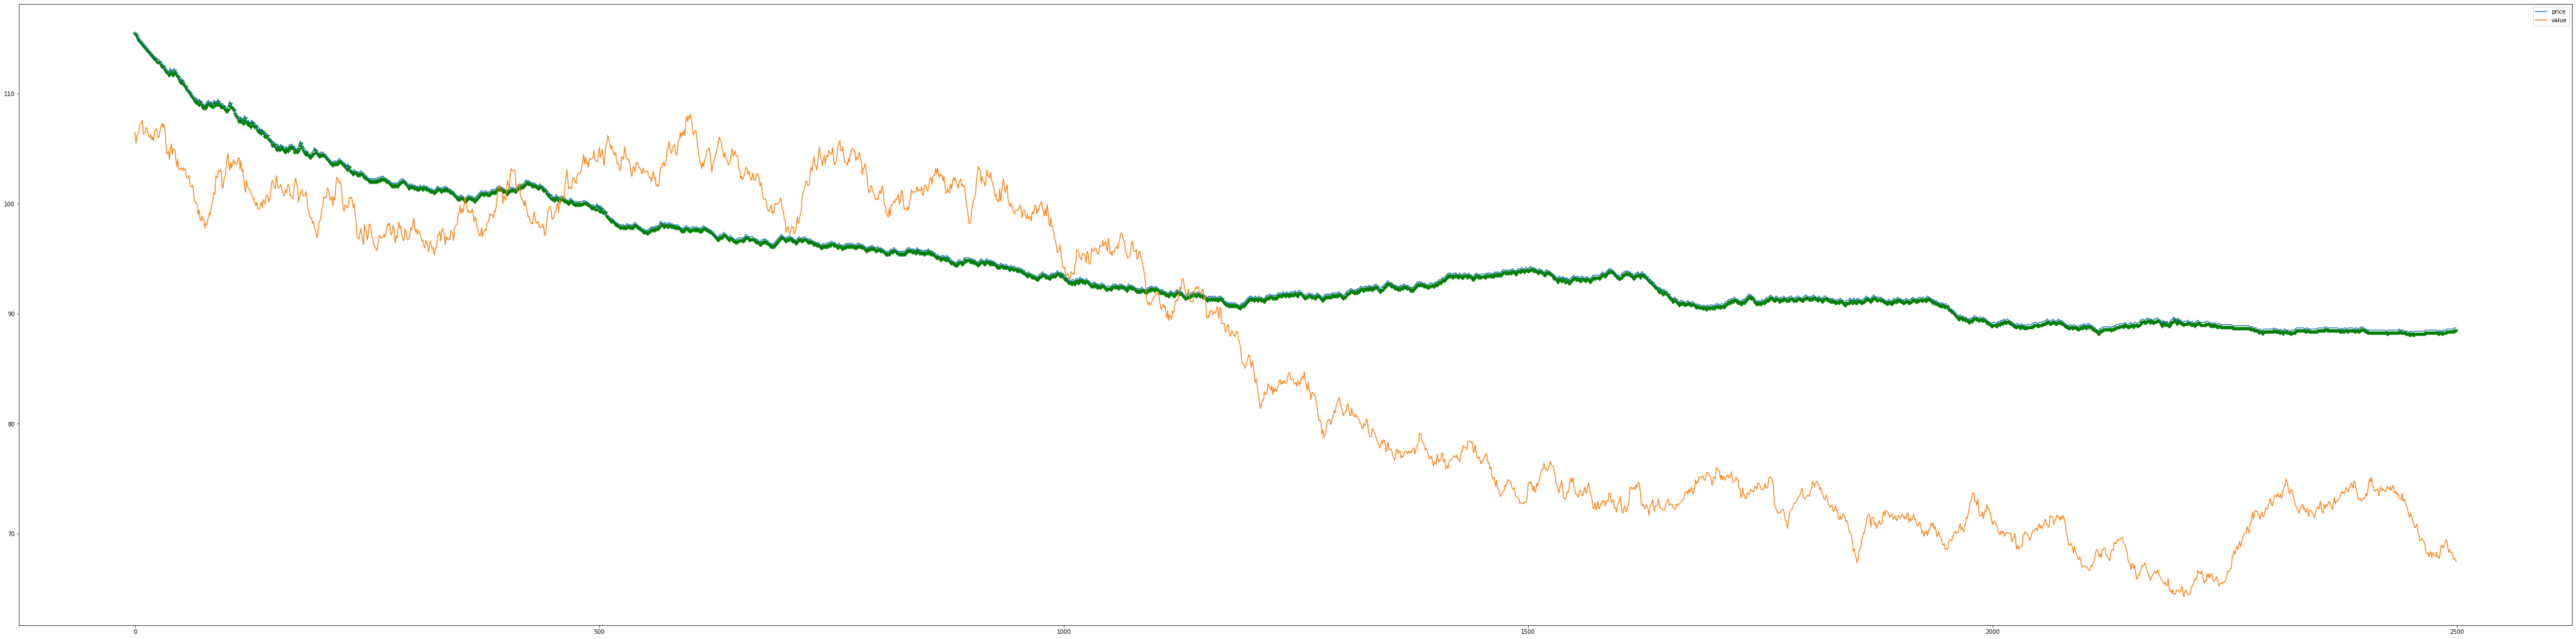

In [754]:
action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}

for state, market in zip(rl_states, markets):
    orders = []
    for i, action in enumerate(state[value_agent_id]['actions']):
        bid_or_ask = action_ref[action[0]]
        ticks = tick_ref[action[1]]
        price = market['price'][249+i] + tick_size * ticks
        volume = action[2] + 1
        order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
        orders.append(order)

    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 10
    for i, order in enumerate(orders):
        if order['bid_or_ask'] == 'BID':
    #         if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
        if order['bid_or_ask'] == 'ASK':
    #         if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])
    plot_price = market['price'][250:]
    plot_value = market['value'][250:]
    x = np.arange(len(plot_price))
    plt.figure(figsize=(80, 20))
    plt.plot(x, plot_price, label = "price")
    plt.plot(x, plot_value, label = "value")
    plt.legend()
    plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

In [739]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 10
for i, order in enumerate(orders):
    if order['bid_or_ask'] == 'BID':
#         if order['time'] > 5000 and order['time'] < 5100:
        bid_x.append(order['time'])
        bid_y.append(order['price'])
        bid_colors.append('r')
        bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
#         if order['time'] > 5000 and order['time'] < 5100:
        ask_x.append(order['time'])
        ask_y.append(order['price'])
        ask_colors.append('g')  
        ask_sizes.append(base_size * order['volume'])

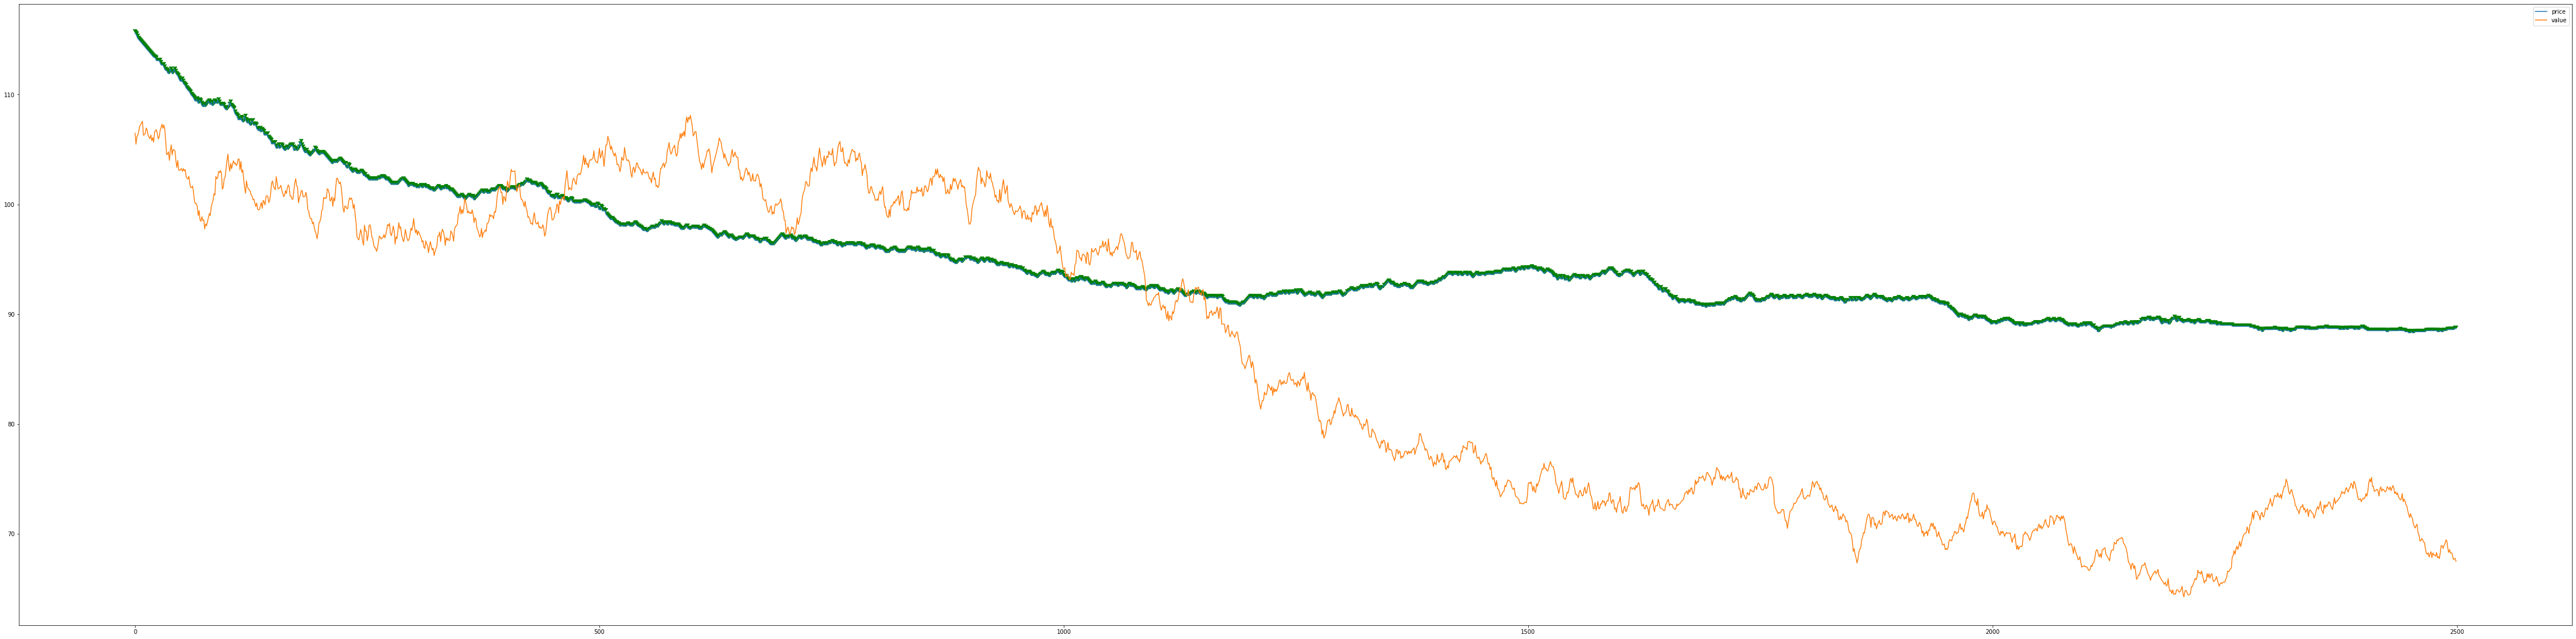

In [741]:
plot_price = market['price'][250:]
plot_value = market['value'][250:]
x = np.arange(len(plot_price))
plt.figure(figsize=(80, 20))
plt.plot(x, plot_price, label = "price")
plt.plot(x, plot_value, label = "value")
plt.legend()
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()



## Agent

In [202]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])

2500

### Holdings

#### Initial state

In [57]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

Number of agents: 1000
Total TSMC: 61311 Total cash: 618009590
Average TSMC: 61 Average cash: 618009
ZI TSMC: 0 ZI cash: 0


#### Wealth

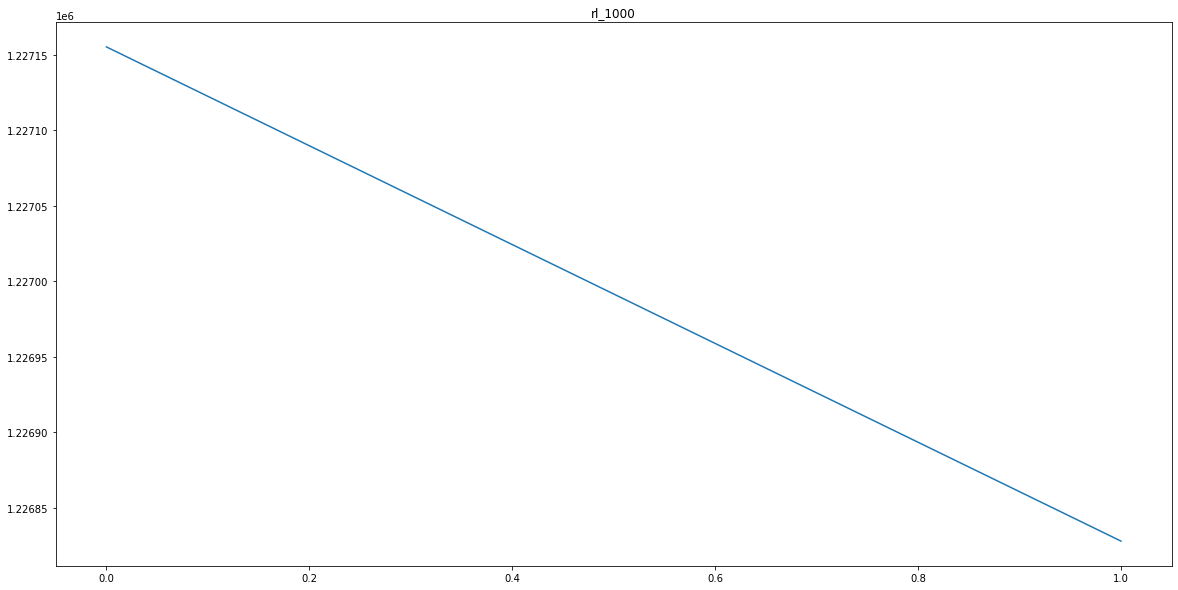

In [13]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

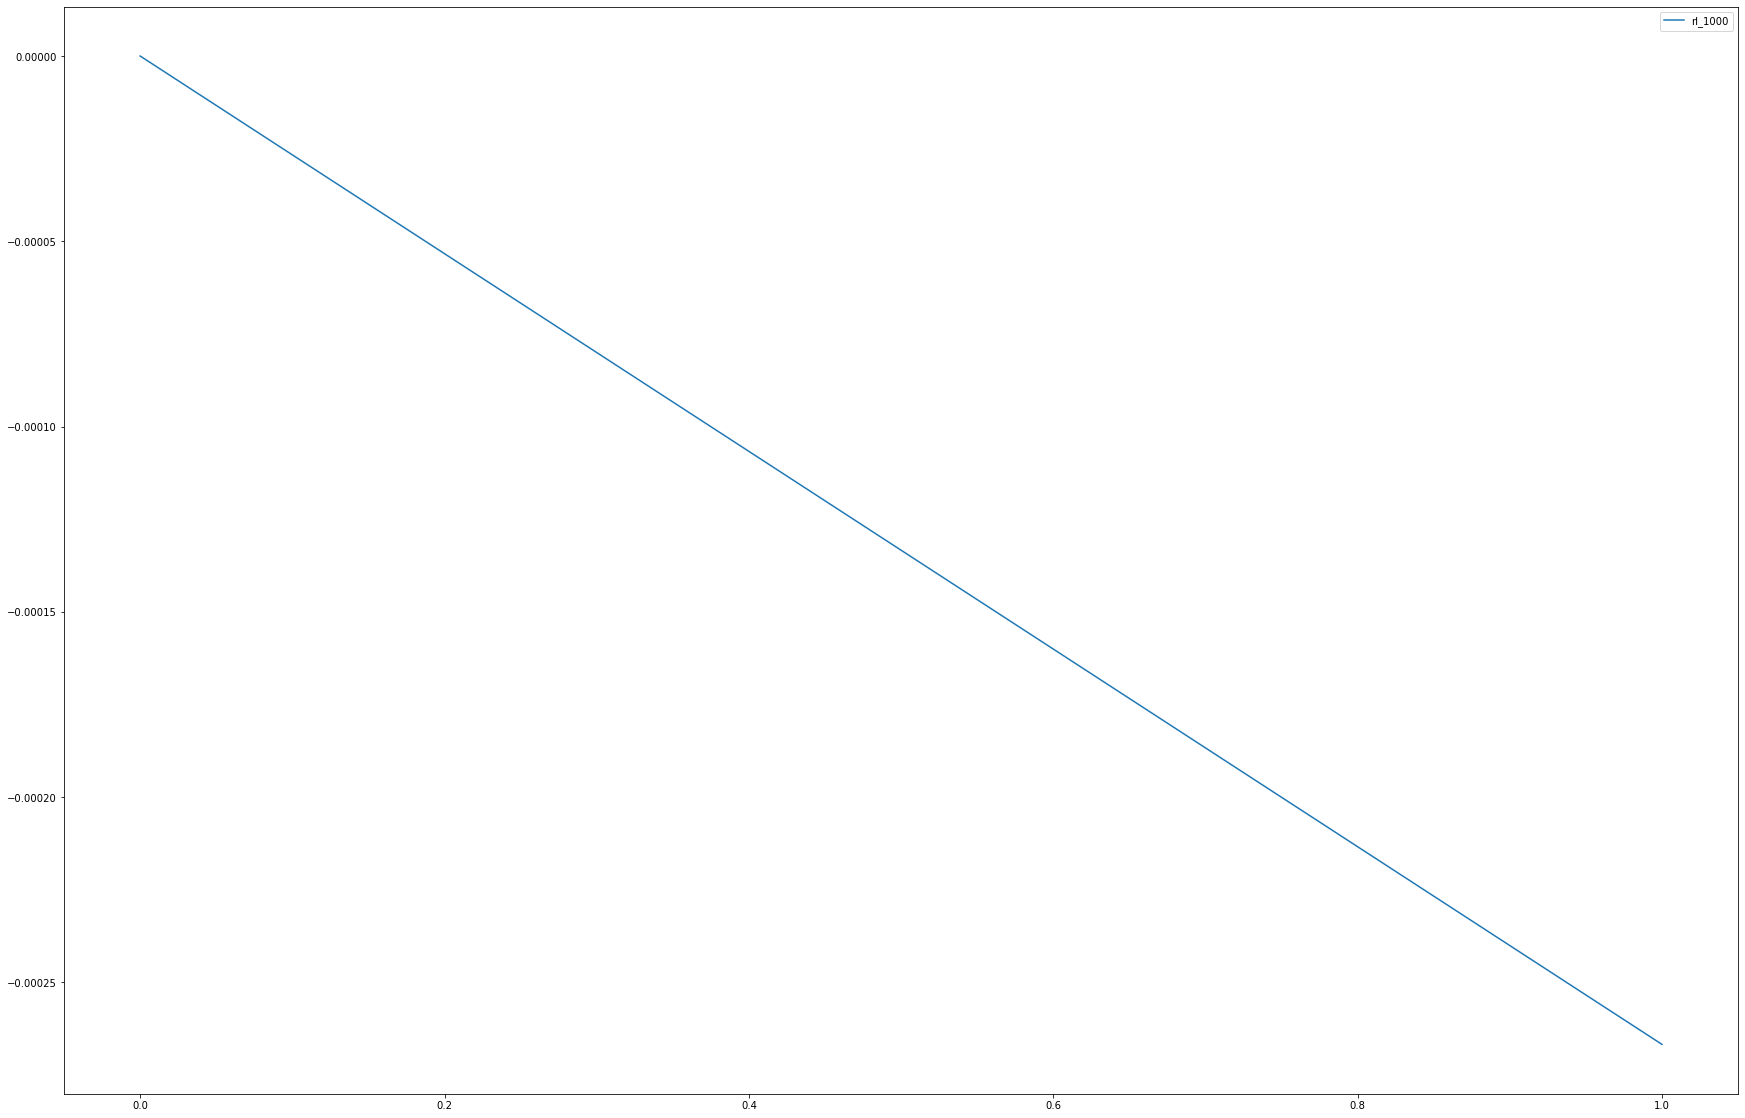

In [14]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

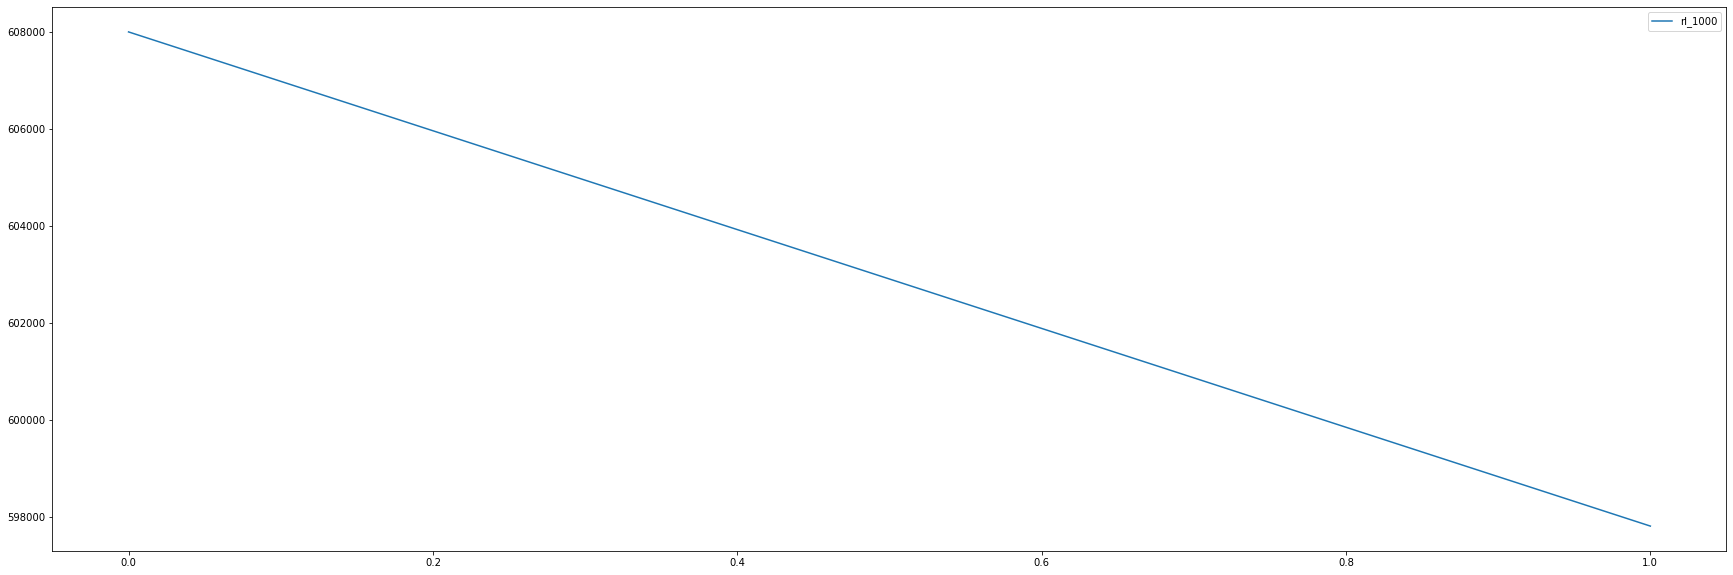

In [15]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

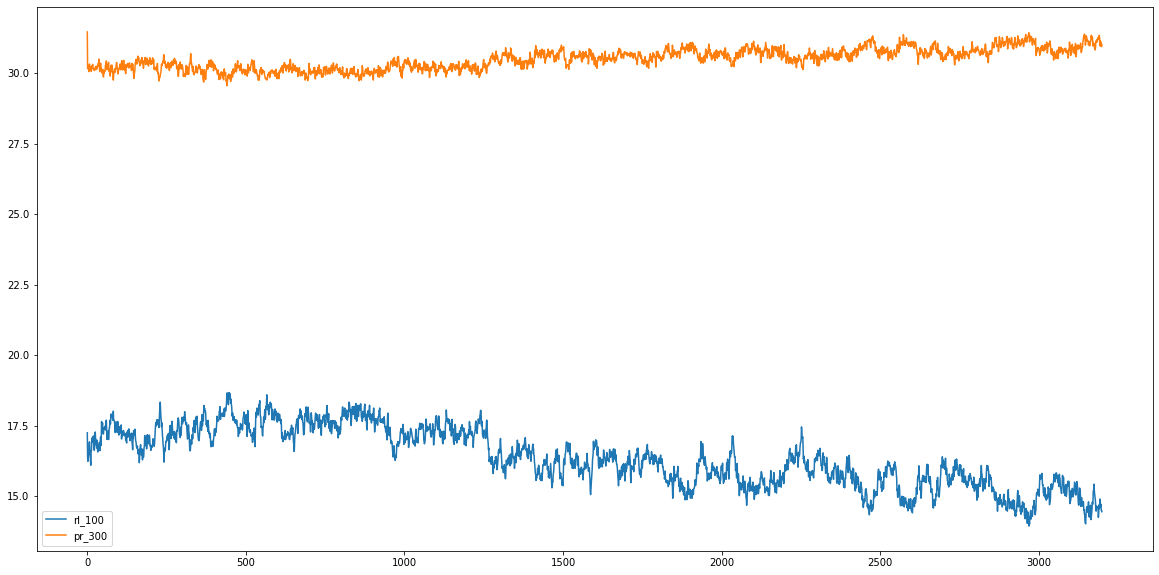

In [21]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [23]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

NameError: name 'tsmc' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

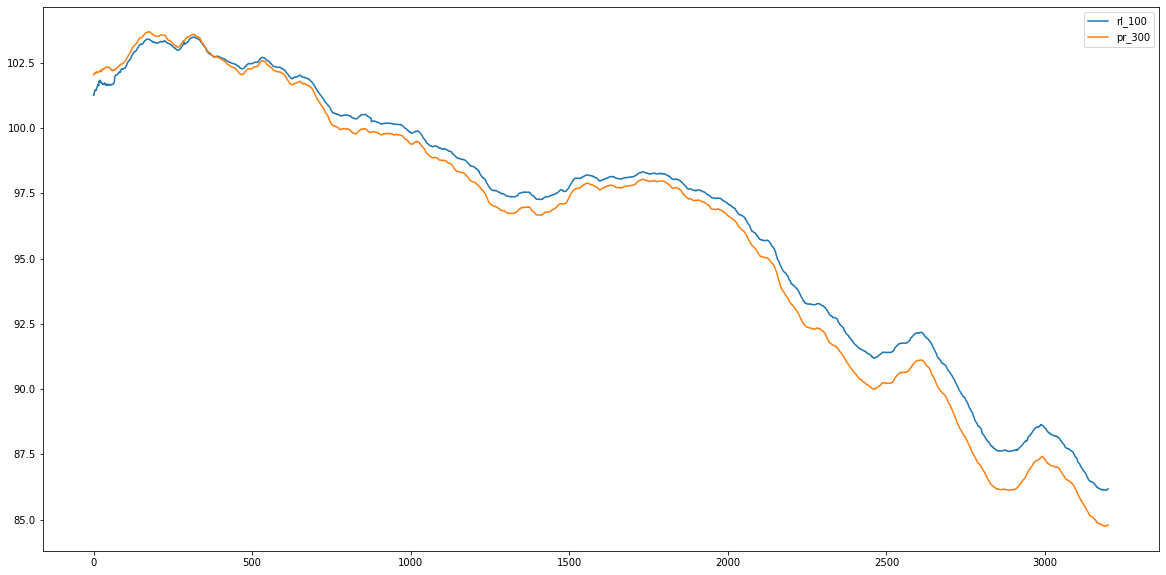

In [24]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

#### Each group

In [25]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


NameError: name 'tsmc' is not defined

#### Propotion

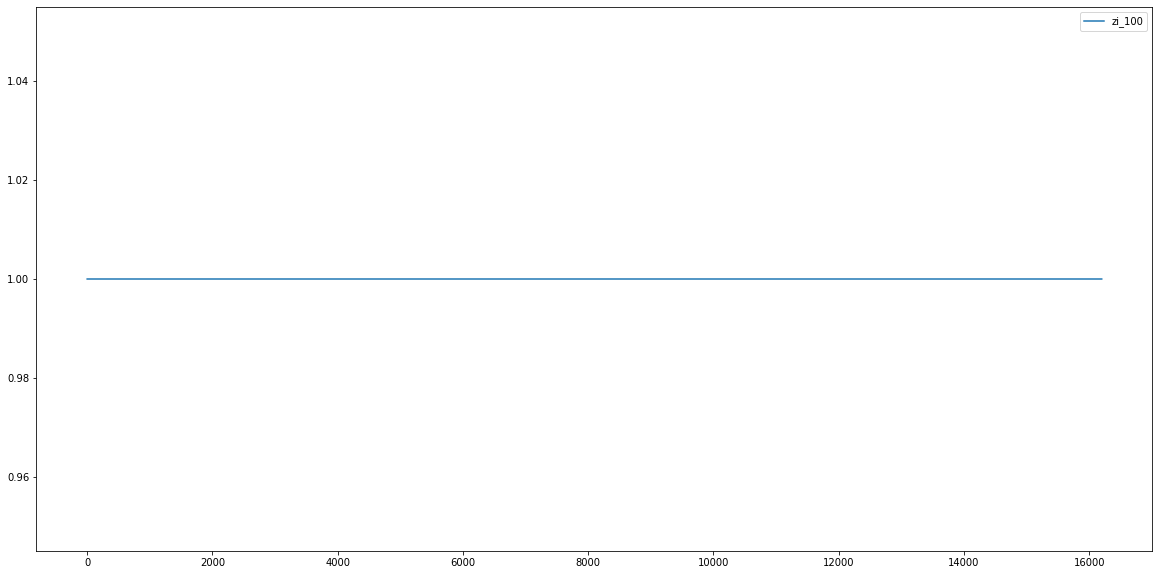

In [90]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## RL Agent

In [5]:
import random

markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
for _dir in validate_dirs:
    record_dir = result_dir / 'validate' / _dir
    security_path = record_dir / "TSMC.json"
    agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
    config_path = result_dir / 'config.json'
    market = json.loads(security_path.read_text())
    markets.append(market)
    agents.append(json.loads(agent_path.read_text()))
    rl_states.append(json.loads(rl_path.read_text()))
    lengths.append(len(market['price']))
    timesteps.append([i for i in range(len(market['price']))])

In [6]:
print(f"Average length: {sum(lengths) / len(lengths)}")

Average length: 1650.4


In [175]:
for timestep, action in enumerate(actions):
    if action[0] == 0:
        bid_x.append(timestep + 100)
        bid_y.append(action[1]*0.1)
        bid_colors.append('r')
        bid_sizes.append(base_size * action[2])
    elif action[0] == 1:
        ask_x.append(timestep + 100)
        ask_y.append(action[1]*0.1)
        ask_colors.append('g')
        ask_sizes.append(base_size * action[2])

ppo_tr_100_35


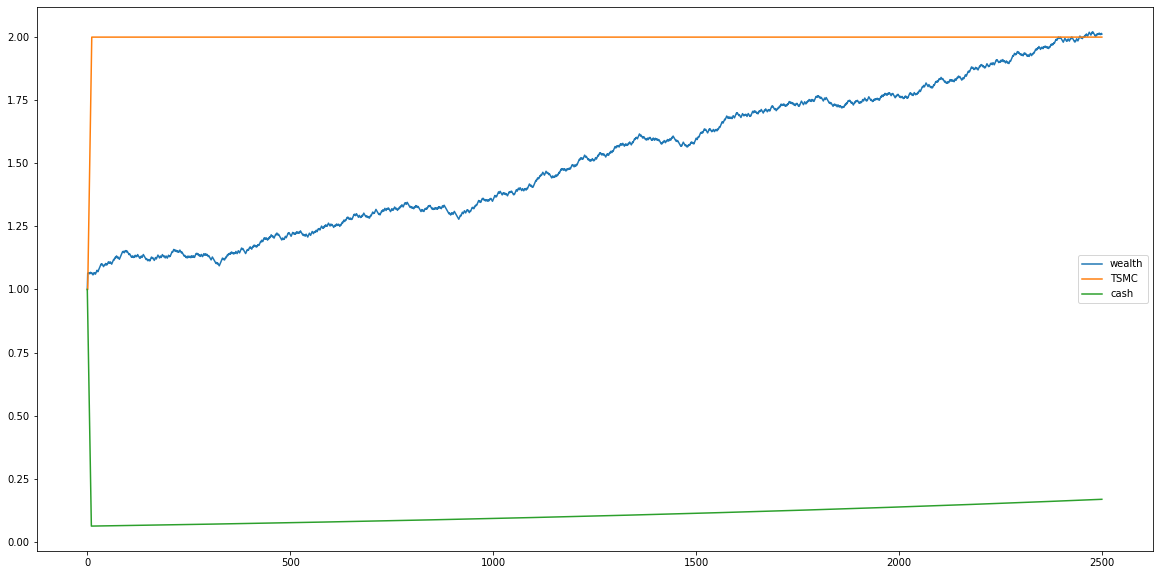

Bid rate: 0.9992, Ask rate: 0.0, Hold rate: 0.0008


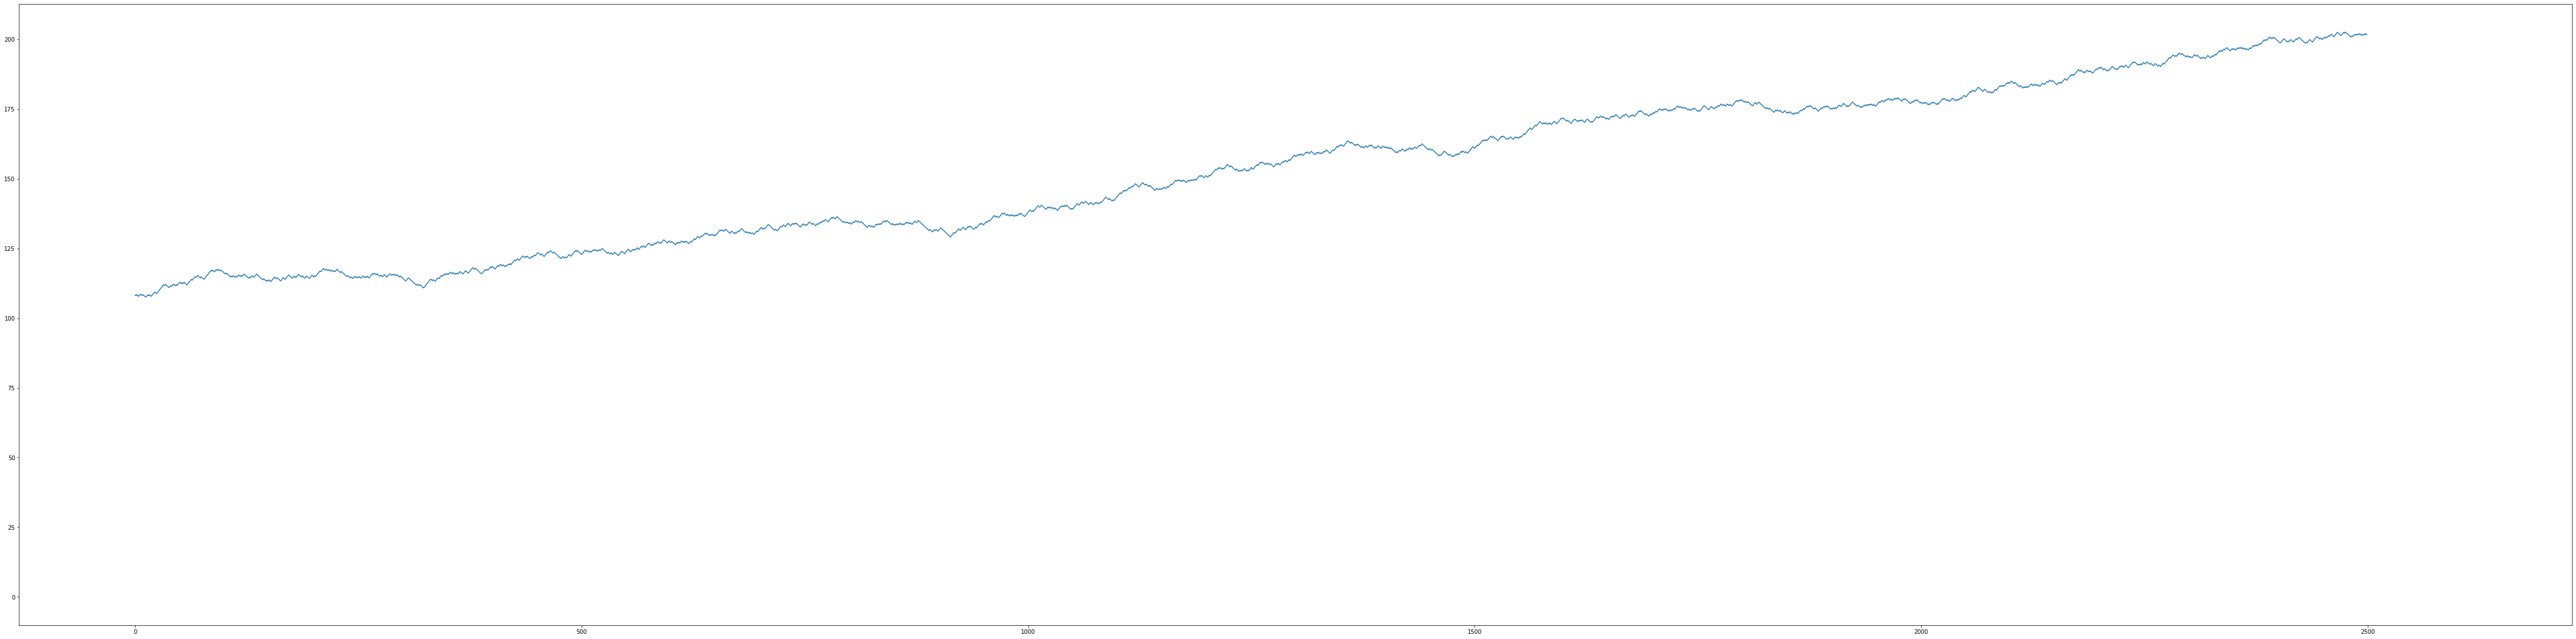

In [186]:
for group in config['Agent']['RLAgent']:
    group_name = group['name']
    group_number = group['number']
    sample_id = f"{group_name}_{group_number}_{random.randint(0, group_number-1)}"
    state = rl_states[sample_id]
    print(sample_id)
    holdings_df = pd.DataFrame(rl_states[sample_id]['states'])
    plt.plot(holdings_df.wealth / holdings_df.wealth[0], label = "wealth")
    plt.plot(holdings_df.TSMC / holdings_df.TSMC[0], label = "TSMC")
    plt.plot(holdings_df.cash / holdings_df.cash[0], label = "cash")
    plt.legend()
    plt.show()
    
    actions = rl_states[sample_id]['actions']
    actions_df = pd.DataFrame(rl_states[sample_id]['actions'], columns = ['action', 'tick', 'volume'])
    print(f"Bid rate: {actions_df.action.eq(0).mean()}, Ask rate: {actions_df.action.eq(1).mean()}, Hold rate: {actions_df.action.eq(2).mean()}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 200
    for timestep, action in enumerate(actions):
        if action[0] == 0:
            bid_x.append(timestep + 100)
            bid_y.append(action[1]*0.1)
            bid_colors.append('r')
            bid_sizes.append(base_size * action[2])
        elif action[0] == 1:
            ask_x.append(timestep + 100)
            ask_y.append(action[1]*0.1)
            ask_colors.append('g')
            ask_sizes.append(base_size * action[2])
            
    x = np.arange(2500)
    plt.figure(figsize=(80, 20))
    plt.plot(x, market['price'][100:])
    plt.scatter(bid_x, a, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

        
    break

### Relation of reward and performance

In [91]:
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)
state = rl_states[agent_id]
rewards = state['rewards']


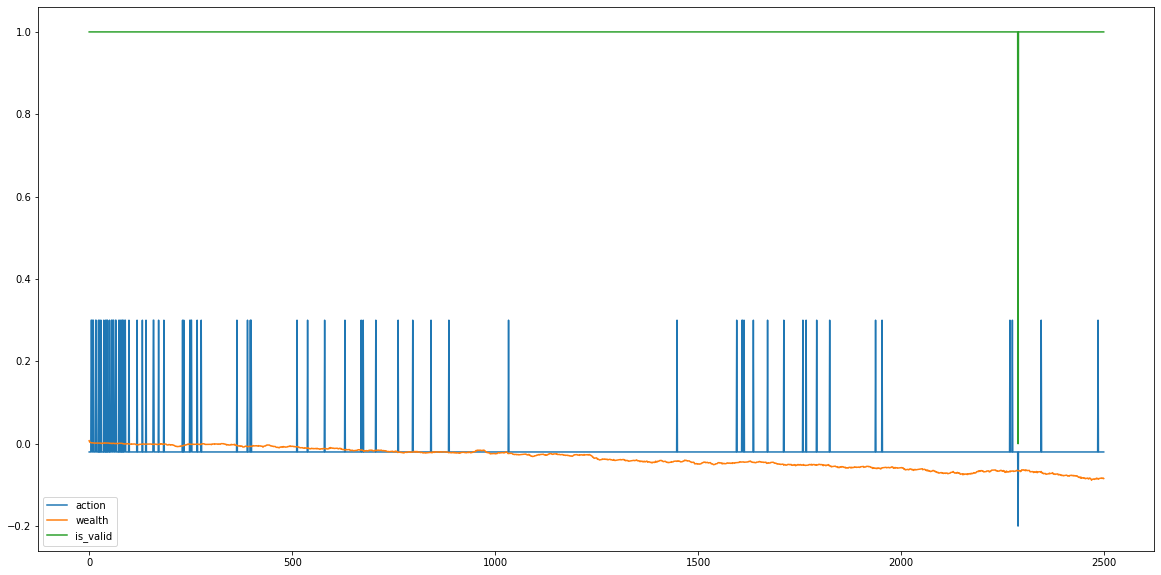

In [92]:
plt.plot(timesteps, rewards, label = ['action', 'wealth', 'is_valid'])
plt.legend()

In [104]:
sim_num = len(train_dirs)
length = len(market['price'][100:])
timesteps = [i for i in range(length)]
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)[0]

total_rewards = []
for i in range(sim_num):
    record_dir = result_dir / 'train' / f'sim_{i}'
#     security_path = record_dir / "TSMC.json"
#     agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
#     market = json.loads(security_path.read_text())
#     agents = json.loads(agent_path.read_text())
    rl_states = json.loads(rl_path.read_text())
    total_rewards.append(rl_states[agent_id]['rewards'])


In [154]:
action_rewards = []
wealth_rewards = []
valid_rewards = []

tr = np.array(total_rewards)
total_reward_by_type = tr.reshape([-1, 3])

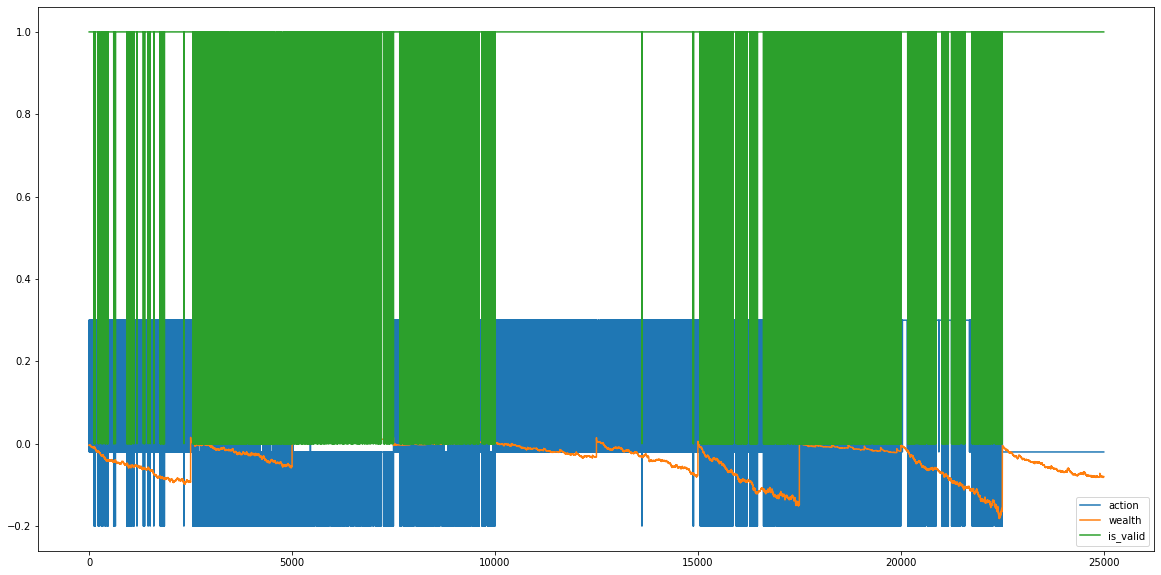

In [156]:
plt.plot(total_reward_by_type, label = ['action', 'wealth', 'is_valid'])
plt.legend()

### Orders

In [33]:
agents.keys()

dict_keys(['ppo_tr_100', 'ppo_va_100', 'ac_tr_100', 'ac_va_100'])

In [32]:
rl_states['ppo_tr_100_0']

{'states': [{'cash': 105999, 'TSMC': 12, 'wealth': 219518.99999999994},
  {'cash': 105999, 'TSMC': 12, 'wealth': 235478.99999999994},
  {'cash': 105999, 'TSMC': 12, 'wealth': 235959.0},
  {'cash': 106041.4, 'TSMC': 12, 'wealth': 235599.0},
  {'cash': 106083.81999999999, 'TSMC': 12, 'wealth': 236121.40000000002},
  {'cash': 106126.24999999999, 'TSMC': 12, 'wealth': 235803.81999999998},
  {'cash': 106168.69999999998, 'TSMC': 12, 'wealth': 235486.24999999997},
  {'cash': 106211.16999999998, 'TSMC': 12, 'wealth': 236008.7},
  {'cash': 106253.64999999998, 'TSMC': 12, 'wealth': 236531.16999999998},
  {'cash': 106296.14999999998, 'TSMC': 12, 'wealth': 236213.64999999997},
  {'cash': 106338.66999999998, 'TSMC': 12, 'wealth': 235896.14999999997},
  {'cash': 106381.20999999998, 'TSMC': 12, 'wealth': 236418.66999999998},
  {'cash': 106423.75999999998, 'TSMC': 12, 'wealth': 236101.20999999996},
  {'cash': 106466.32999999999, 'TSMC': 12, 'wealth': 235783.75999999995},
  {'cash': 106508.91999999998,

### Distribution of actions along times from random agent

In [26]:
prices = market['price'][100:]
bids = market['bid_five_price']
asks = market['ask_five_price']
bid_or_asks = []
agent_id = random.sample(agent_ids, 1)[0]
state = rl_states[agent_id]
counters = []
for agent_id, state in rl_states.items():
    bid_or_asks = []
    for i, action in enumerate(state['actions']):
        bid_or_ask = action[0]
        ticks = action[1]
        volume = action[2] + 1
        current_price = prices[i]
        tick_size = 0.1

        if bid_or_ask == 2:
            pass
        elif bid_or_ask == 0:
            # bid
            best_bids = list(bids[i])
            best_bid = current_price if len(best_bids) == 0 else float(best_bids[0])
            price = round(best_bid + (4-ticks) * tick_size, 2)

        elif bid_or_ask == 1:
            # ask
            best_asks = list(asks[i])
            best_ask = current_price if len(best_asks) == 0 else float(best_asks[0])
            price = round(best_ask + (ticks-4) * tick_size, 2)
        bid_or_asks.append(bid_or_ask)


    counter = {0: 0, 1: 0, 2: 0}
    for a in bid_or_asks:
        counter[a] += 1
    counters.append(counter)


In [81]:
hold_times = {i: 0 for i in range(length+1)}
bid_times = {i: 0 for i in range(length+1)}
ask_times = {i: 0 for i in range(length+1)}

for counter in counters:
    bid_times[counter[0]] += 1
    ask_times[counter[1]] += 1
    hold_times[counter[2]] += 1
    

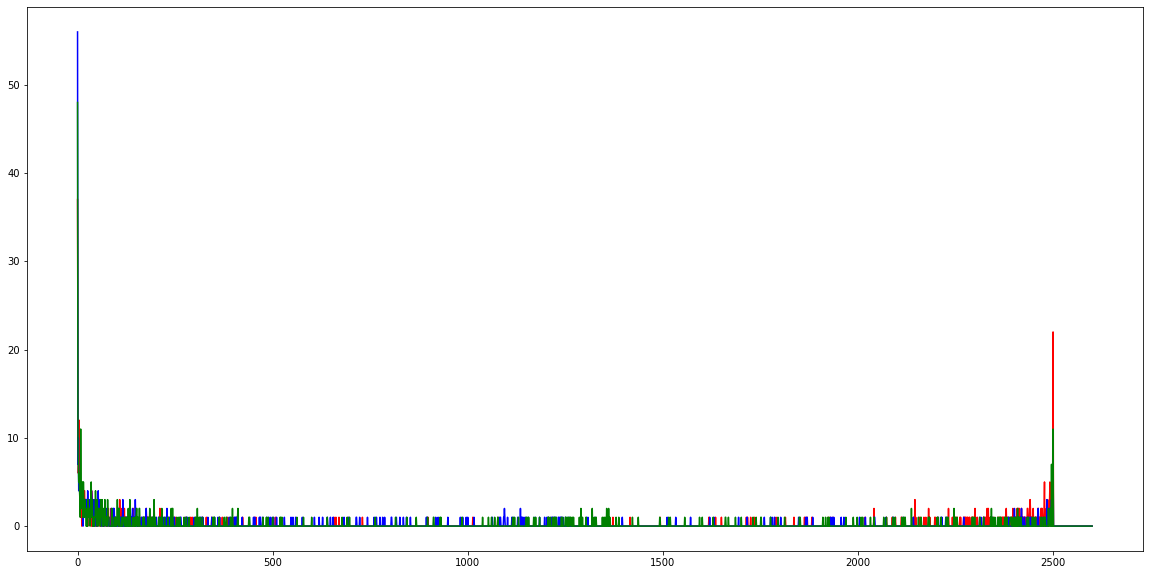

In [68]:
plt.plot(timesteps, list(hold_times.values()), 'r')
plt.plot(timesteps, list(bid_times.values()), 'b')
plt.plot(timesteps, list(ask_times.values()), 'g')

In [43]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

KeyError: 'states'

In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()